<a href="https://colab.research.google.com/github/Nastiiasaenko/Deeplearning-Final-Project/blob/main/Confidence_Score_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/combined_data.zip" -d "/content/drive/My Drive/"



Archive:  /content/drive/My Drive/combined_data.zip
replace /content/drive/My Drive/combined_data.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/My Drive/combined_data.pt  


In [ ]:
import torch

# Load the dataset
combined_data_path = "/content/drive/My Drive/combined_data.pt"
combined_data = torch.load(combined_data_path)


<ipython-input-3-bf9beba35566>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_data = torch.load(combined_data_path)


In [ ]:
print(len(combined_data['input_ids']))

91063


In [ ]:
import torch



input_ids = combined_data['input_ids']
attention_mask = combined_data['attention_mask']
labels = combined_data['labels']

In [ ]:
len(input_ids)

91063

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Load model and data
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move model to GPU



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch

def get_confidence_scores(model, input_ids, attention_mask, device='cpu'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)
    return probabilities


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Confidence Score using Single Model

In [ ]:
dataset = TensorDataset(input_ids, attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

all_confidences = []
all_labels = []  # If needed for later analysis

for batch in dataloader:
    input_ids_batch, attention_mask_batch, labels_batch = batch
    probabilities = get_confidence_scores(model, input_ids_batch, attention_mask_batch, device=device)
    all_confidences.extend(probabilities.cpu().numpy())  # Collect confidence scores
    all_labels.extend(labels_batch.numpy())  # Collect labels (if needed)

print(f"Processed {len(all_confidences)} samples out of {len(dataset)}.")


Processed 91063 samples out of 91063.


In [ ]:
torch.save(all_confidences, 'all_confidences.pt')


In [ ]:
from google.colab import files

# Download the file
files.download('all_confidences.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
confidences = np.array(all_confidences)

min_confidences = confidences.min(axis=0)
max_confidences = confidences.max(axis=0)

print(f"Class 0 Confidence Range: {min_confidences[0]} - {max_confidences[0]}")
print(f"Class 1 Confidence Range: {min_confidences[1]} - {max_confidences[1]}")


Class 0 Confidence Range: 0.24107573926448822 - 0.7203733325004578
Class 1 Confidence Range: 0.27962663769721985 - 0.7589242458343506


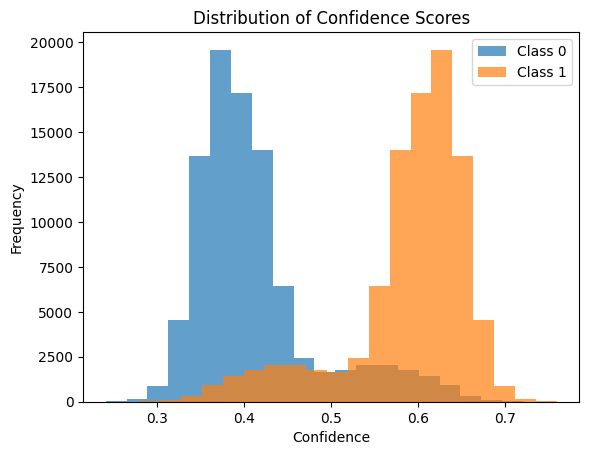

In [ ]:
import matplotlib.pyplot as plt

plt.hist(confidences[:, 0], bins=20, alpha=0.7, label='Class 0')
plt.hist(confidences[:, 1], bins=20, alpha=0.7, label='Class 1')
plt.legend()
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.show()


In [ ]:
len(all_confidences)

91063

In [ ]:
# import numpy as np

# # Convert all_confidences to a NumPy array if it isn’t one already
# all_confidences = np.array(all_confidences)

# # Apply thresholds with NumPy's `where` function
# ood_flags = np.where(
#     all_confidences < low_threshold, 1,  # OOD
#     np.where(all_confidences > high_threshold, 0, -1)  # ID or uncertain
# )

# # Convert ood_flags back to a list if needed
# ood_flags = ood_flags.tolist()


In [ ]:
all_confidences = torch.tensor(all_confidences)

# Perform the operation
predicted_classes = (all_confidences[:, 1] > 0.6).to(dtype=torch.int)
print(predicted_classes)


tensor([1, 1, 0,  ..., 1, 1, 1], dtype=torch.int32)


<ipython-input-62-0b9997864a24>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_confidences = torch.tensor(all_confidences)


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming `predicted_classes` and `true_labels` are your predictions and labels
accuracy = accuracy_score(labels, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.72


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    accuracy_score,
    ConfusionMatrixDisplay
)


Playing with different thresholds


Detection Accuracy: 0.71
Precision: 0.51
Recall: 0.96
F1 Score: 0.66


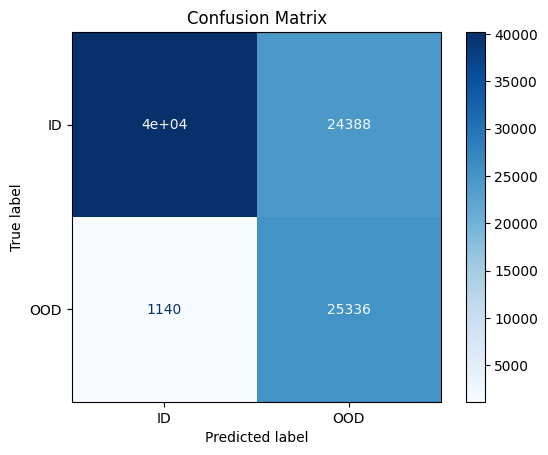

In [ ]:
precision = precision_score(labels, predicted_classes)
recall = recall_score(labels, predicted_classes)
f1 = f1_score(labels, predicted_classes)

print(f"Detection Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ID", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



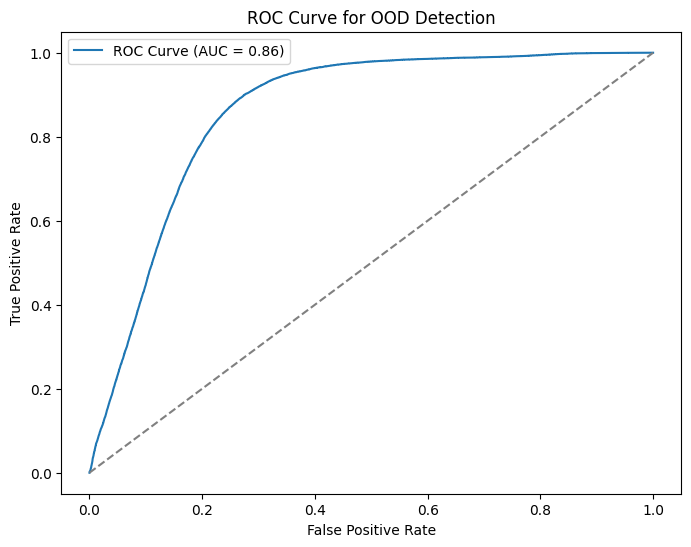

In [ ]:
labels = labels if len(labels.shape) == 1 else labels.argmax(axis=-1)

# Ensure confidences are 1D
all_confidences = all_confidences[:, 1]  # Extract confidence scores for the positive class

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(labels, all_confidences)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for OOD Detection")
plt.legend()
plt.show()


Accuracy 0.71 and recall 0.76 , we might want more recall as we want as many OODs as possible not accuracy

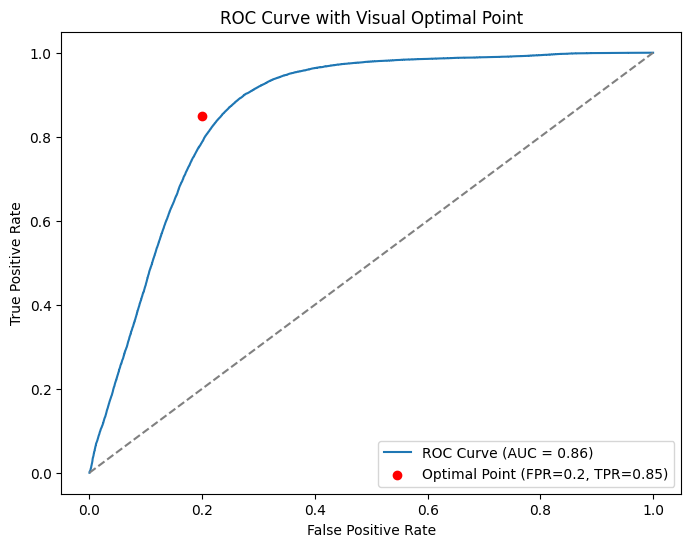

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line

# Visually identified optimal point
optimal_fpr = 0.2  # Approximate value from visual inspection
optimal_tpr = 0.85  # Approximate value from visual inspection

# Mark the optimal point
plt.scatter(optimal_fpr, optimal_tpr, color='red', label=f"Optimal Point (FPR={optimal_fpr}, TPR={optimal_tpr})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Visual Optimal Point")
plt.legend()
plt.show()


In [ ]:
optimal_index = np.argmin(np.abs(fpr - 0.2))
print(optimal_index)
optimal_threshold = thresholds[optimal_index]
print(optimal_threshold)

27
0.2116854


Threshold corresponding to FPR ≈ 0.2: 0.6216403245925903
Detection Accuracy: 0.80
Precision: 0.62
Recall: 0.79
F1 Score: 0.69


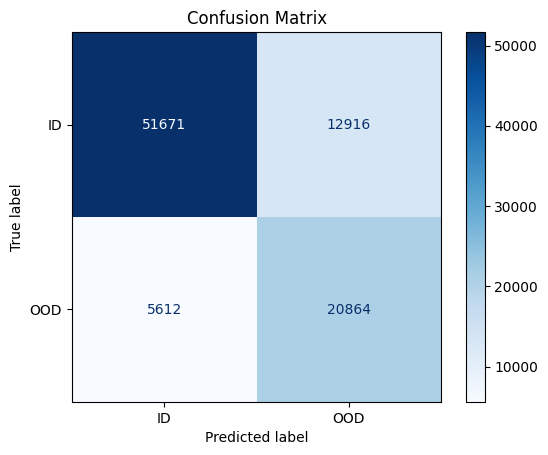

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt

# Assuming `labels` and `all_confidences` are already defined

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(labels.cpu().numpy(), all_confidences.cpu().numpy())

# Find the threshold corresponding to FPR ≈ 0.2
fpr_target = 0.2
optimal_index = np.argmin(np.abs(fpr - fpr_target))
optimal_threshold = thresholds[optimal_index]

print(f"Threshold corresponding to FPR ≈ {fpr_target}: {optimal_threshold}")

# Use the threshold to calculate predicted classes
predicted_classes = (all_confidences >= optimal_threshold).to(dtype=torch.int)

# Ensure labels and predictions are NumPy arrays
labels_np = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else labels
predicted_classes_np = predicted_classes.cpu().numpy() if isinstance(predicted_classes, torch.Tensor) else predicted_classes

# Compute metrics
accuracy = accuracy_score(labels_np, predicted_classes_np)
precision = precision_score(labels_np, predicted_classes_np)
recall = recall_score(labels_np, predicted_classes_np)
f1 = f1_score(labels_np, predicted_classes_np)

# Print metrics
print(f"Detection Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(labels_np, predicted_classes_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ID", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Reducing the threshold to 0.21 increases accuracy but reduce recall which doesn't suit our use case.

**Ensemble Models**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_names = ["bert-base-uncased", "roberta-base", "distilbert-base-uncased"]
models = []
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

for model_name in model_names:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)  # Move model to the specified device
    model.eval()  # Set model to evaluation mode
    models.append(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
from torch.cuda.amp import autocast

def ensemble_predictions(models, input_ids, attention_mask):
    all_probabilities = []

    for model in models:
        with torch.no_grad():
            input_ids = input_ids.to(next(model.parameters()).device)
            attention_mask = attention_mask.to(next(model.parameters()).device)

            # Enable mixed precision
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_probabilities.append(probabilities)

    all_probabilities = torch.stack(all_probabilities)
    aggregated_probabilities = all_probabilities.mean(dim=0)
    return aggregated_probabilities


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
model_names = ["bert-base-uncased", "roberta-base"]
models = []
for name in model_names:
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=2)
    model.to(device)
    model.eval()
    models.append(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader with smaller batch size
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=4)  # Reduce batch size (e.g., from 32 to 4)

# Process each batch separately
all_aggregated_probabilities = []
for batch in dataloader:
    input_ids_batch, attention_mask_batch = batch[0].to(device), batch[1].to(device)
    aggregated_probabilities = ensemble_predictions(models, input_ids_batch, attention_mask_batch)
    all_aggregated_probabilities.append(aggregated_probabilities.cpu())

<ipython-input-76-fc2886dbf217>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
import torch

# Concatenate all tensors along the first dimension
all_aggregated_probabilities = torch.cat(all_aggregated_probabilities, dim=0)
torch.save(all_aggregated_probabilities, 'all_aggregated_probabilities.pt')


In [ ]:
from google.colab import files

# Download the file
files.download('all_aggregated_probabilities.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

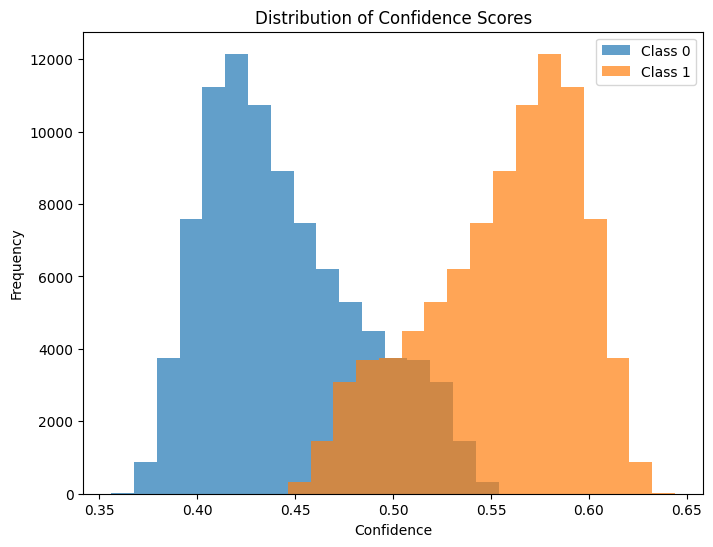

In [ ]:
# all_aggregated_probabilities_concat = torch.cat(all_aggregated_probabilities, dim=0)

# Convert to NumPy
all_aggregated_probabilities_np = all_aggregated_probabilities_concat.cpu().numpy()

# Extract confidences for each class
class_0_confidences = all_aggregated_probabilities_np[:, 0]
class_1_confidences = all_aggregated_probabilities_np[:, 1]

# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(class_0_confidences, bins=20, alpha=0.7, label="Class 0")
plt.hist(class_1_confidences, bins=20, alpha=0.7, label="Class 1")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores")
plt.legend()
plt.show()


In [ ]:
# Assuming `labels` is a 1D NumPy array
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))
print(f"Label Counts: {label_counts}")


Label Counts: {0.0: 64587, 1.0: 26476}


In [ ]:
import numpy as np
import torch

# Assuming labels and all_aggregated_probabilities_concat are defined
# labels: 1D NumPy array or PyTorch tensor
# all_aggregated_probabilities_concat: 2D NumPy array or PyTorch tensor

# Convert to NumPy for processing
if isinstance(labels, torch.Tensor):
    labels_np = labels.cpu().numpy()
else:
    labels_np = labels

if isinstance(all_aggregated_probabilities_concat, torch.Tensor):
    probabilities_np = all_aggregated_probabilities_concat.cpu().numpy()
else:
    probabilities_np = all_aggregated_probabilities_concat

# Indices for labels 0 and 1
indices_0 = np.where(labels_np == 0)[0]
indices_1 = np.where(labels_np == 1)[0]

# Find the smaller count
min_count = min(len(indices_0), len(indices_1))

# Select equal number of samples for both classes
selected_indices_0 = indices_0[:min_count]
selected_indices_1 = indices_1[:min_count]

# Combine indices and shuffle
selected_indices = np.concatenate([selected_indices_0, selected_indices_1])
np.random.shuffle(selected_indices)

# Subset labels and probabilities
balanced_labels = labels_np[selected_indices]
balanced_probabilities = probabilities_np[selected_indices]

# Convert back to PyTorch tensors (if needed)
balanced_labels_tensor = torch.tensor(balanced_labels)
balanced_probabilities_tensor = torch.tensor(balanced_probabilities)

# Print results
print(f"Balanced Labels Shape: {balanced_labels.shape}")
print(f"Balanced Probabilities Shape: {balanced_probabilities.shape}")


Balanced Labels Shape: (52952,)
Balanced Probabilities Shape: (52952, 2)


Predicted Classes: tensor([1, 1, 1,  ..., 0, 1, 1], dtype=torch.int32)
Accuracy: 56.04%
Detection Accuracy: 0.56
Precision: 0.53
Recall: 0.93
F1 Score: 0.68


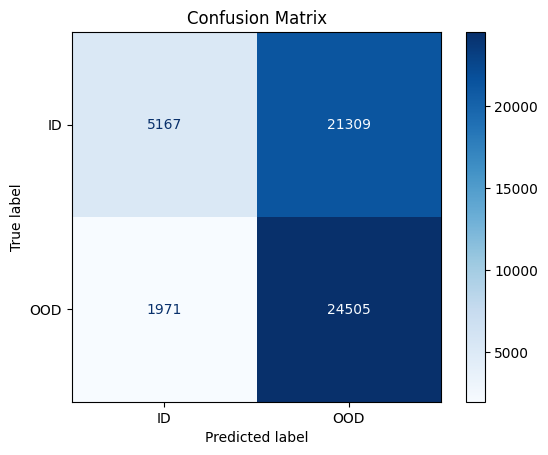

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch

# Assuming balanced_labels_tensor and balanced_probabilities_tensor are defined
# and already converted to PyTorch tensors

# Predicted Classes
predicted_classes1 = (balanced_probabilities_tensor[:, 1] > 0.50).to(dtype=torch.int)

# Ensure labels are on the same device as predictions
balanced_labels_tensor = balanced_labels_tensor.to(predicted_classes1.device)

# Compute correct predictions
correct_predictions = (predicted_classes1 == balanced_labels_tensor).sum().item()

# Calculate accuracy
accuracy = correct_predictions / len(balanced_labels_tensor)

print(f"Predicted Classes: {predicted_classes1}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(balanced_labels_tensor.cpu(), predicted_classes1.cpu())
recall = recall_score(balanced_labels_tensor.cpu(), predicted_classes1.cpu())
f1 = f1_score(balanced_labels_tensor.cpu(), predicted_classes1.cpu())

print(f"Detection Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(balanced_labels_tensor.cpu(), predicted_classes1.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ID", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
predicted_classes1 = (all_aggregated_probabilities_concat[:, 1] > 0.55).to(dtype=torch.int)

# Ensure labels are on the same device as predictions
labels = labels.to(predicted_classes1.device)

# Compute correct predictions
correct_predictions = (predicted_classes1 == labels).sum().item()

# Calculate accuracy
accuracy = correct_predictions / len(labels)

print(f"Predicted Classes: {predicted_classes}")
print(f"Accuracy: {accuracy * 100:.2f}%")


Predicted Classes: tensor([True, True, True,  ..., True, True, True])
Accuracy: 47.68%


Detection Accuracy: 0.48
Precision: 0.31
Recall: 0.66
F1 Score: 0.42


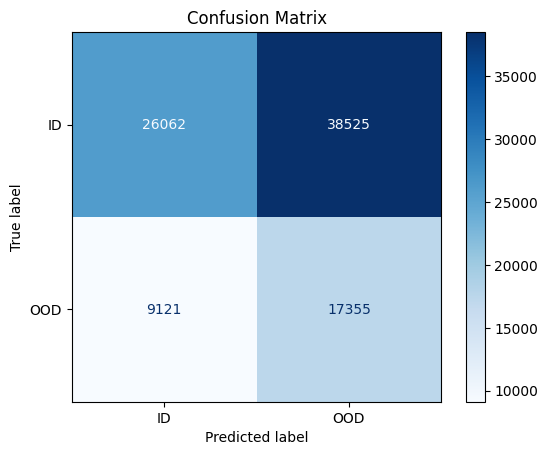

In [ ]:
precision = precision_score(labels, predicted_classes1)
recall = recall_score(labels, predicted_classes1)
f1 = f1_score(labels, predicted_classes1)

print(f"Detection Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(labels, predicted_classes1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ID", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



With ensemble methods, similar recall but a little reduced accuracy

In [ ]:
len(all_aggregated_probabilities)

91063

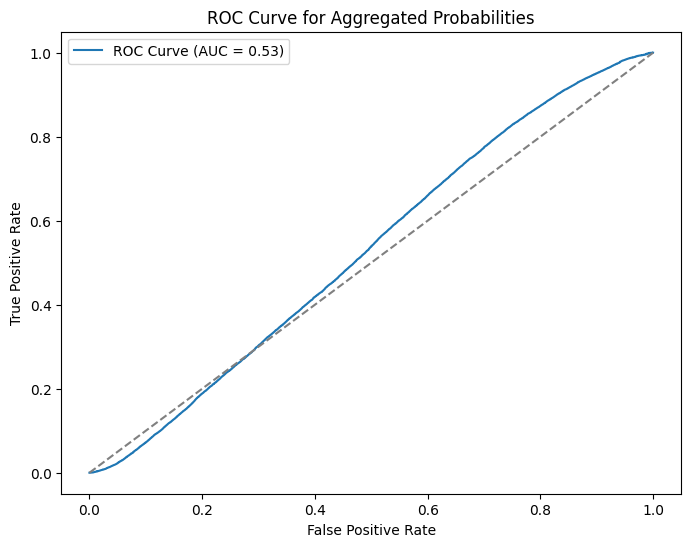

In [ ]:
positive_class_probs = all_aggregated_probabilities[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, positive_class_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Aggregated Probabilities")
plt.legend()
plt.show()


In [ ]:
!pip install transformers datasets peft accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
if isinstance(labels, torch.Tensor):
    labels_np = labels.cpu().numpy()
else:
    labels_np = labels

if isinstance(input_ids, torch.Tensor):
    input_ids_np = input_ids.cpu().numpy()
else:
    input_ids_np = input_ids

if isinstance(attention_mask, torch.Tensor):
    attention_mask_np = attention_mask.cpu().numpy()
else:
    attention_mask_np = attention_mask

# Find indices for labels 0 and 1
indices_0 = np.where(labels_np == 0)[0]
indices_1 = np.where(labels_np == 1)[0]

# Find the minimum count between the two classes
min_count = min(len(indices_0), len(indices_1))

# Randomly select `min_count` samples from each class
selected_indices_0 = np.random.choice(indices_0, min_count, replace=False)
selected_indices_1 = np.random.choice(indices_1, min_count, replace=False)

# Combine indices and shuffle them
balanced_indices = np.concatenate([selected_indices_0, selected_indices_1])
np.random.shuffle(balanced_indices)

# Subset the data based on balanced indices
balanced_input_ids = input_ids_np[balanced_indices]
balanced_attention_mask = attention_mask_np[balanced_indices]
balanced_labels = labels_np[balanced_indices]

# Convert back to PyTorch tensors if needed
balanced_input_ids_tensor = torch.tensor(balanced_input_ids)
balanced_attention_mask_tensor = torch.tensor(balanced_attention_mask)
balanced_labels_tensor = torch.tensor(balanced_labels).to(dtype=torch.int)

# Print summary
print(f"Original Dataset Size: {len(labels)}")
print(f"Balanced Dataset Size: {len(balanced_labels_tensor)}")
print(f"Balanced Label Counts: {torch.bincount(balanced_labels_tensor)}")


Original Dataset Size: 91063
Balanced Dataset Size: 52952
Balanced Label Counts: tensor([26476, 26476])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_data, mask_data, labels):
        self.input_data = input_data
        self.mask_data = mask_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.mask_data[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure torch.long
        }


# Create the dataset with the balanced data
balanced_dataset = CustomDataset(
    balanced_input_ids_tensor,
    balanced_attention_mask_tensor,
    balanced_labels_tensor
)


In [ ]:
from transformers import BertForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
import torch

# Load pre-trained BERT and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Freeze all layers except classification head
for param in model.bert.parameters():
    param.requires_grad = False

# Configure LoRA
# LoRA can be applied to attention layers within the BERT model
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # Low-rank dimension
    lora_alpha=32,
    target_modules=["query", "value"],  # LoRA will modify attention layers
    lora_dropout=0.1
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("LoRA model configured and loaded onto device.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA model configured and loaded onto device.


**Model Finetuning**

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import torch

# DataLoader setup
train_loader = DataLoader(
    balanced_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Gradient accumulation setup
accumulation_steps = 4
gradient_accumulation_counter = 0

# Training loop with optimizations
model.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in range(3):  # Number of epochs
    running_loss = 0.0
    for step, batch in enumerate(train_loader):
        # Move batch to GPU
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        batch["labels"] = batch["labels"].to(dtype=torch.long)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss
            running_loss += loss.item()

        # Backward pass
        scaler.scale(loss / accumulation_steps).backward()

        # Gradient accumulation
        gradient_accumulation_counter += 1
        if gradient_accumulation_counter % accumulation_steps == 0:
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()  # Step the scheduler with each optimizer step

        # Update progress bar
        progress_bar.update(1)

        # Log every 10 steps
        if step % 10 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Loss: {running_loss / (step + 1):.4f}")

    print(f"Epoch {epoch + 1} completed. Average Loss: {running_loss / len(train_loader):.4f}")

    # Save model after each epoch
    model.save_pretrained(f"model_epoch_{epoch + 1}")
    tokenizer.save_pretrained(f"model_epoch_{epoch + 1}")

print("Training complete.")


<ipython-input-156-16b541970650>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()

  0%|          | 0/4965 [04:05<?, ?it/s]
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTens

Epoch 1, Step 0, Loss: 0.6501



  0%|          | 12/4965 [00:02<10:29,  7.87it/s]

Epoch 1, Step 10, Loss: 0.7242



  0%|          | 22/4965 [00:03<08:22,  9.84it/s]

Epoch 1, Step 20, Loss: 0.7267



  1%|          | 32/4965 [00:04<09:13,  8.91it/s]

Epoch 1, Step 30, Loss: 0.7278



  1%|          | 42/4965 [00:05<08:13,  9.98it/s]

Epoch 1, Step 40, Loss: 0.7276



  1%|          | 52/4965 [00:06<09:15,  8.84it/s]

Epoch 1, Step 50, Loss: 0.7275



  1%|          | 62/4965 [00:07<08:12,  9.95it/s]

Epoch 1, Step 60, Loss: 0.7245



  1%|▏         | 72/4965 [00:08<09:08,  8.92it/s]

Epoch 1, Step 70, Loss: 0.7207



  2%|▏         | 82/4965 [00:09<08:10,  9.96it/s]

Epoch 1, Step 80, Loss: 0.7171



  2%|▏         | 92/4965 [00:10<09:05,  8.94it/s]

Epoch 1, Step 90, Loss: 0.7163



  2%|▏         | 102/4965 [00:11<08:06,  9.99it/s]

Epoch 1, Step 100, Loss: 0.7138



  2%|▏         | 112/4965 [00:12<09:05,  8.90it/s]

Epoch 1, Step 110, Loss: 0.7093



  2%|▏         | 122/4965 [00:13<08:11,  9.85it/s]

Epoch 1, Step 120, Loss: 0.7046



  3%|▎         | 132/4965 [00:14<09:02,  8.91it/s]

Epoch 1, Step 130, Loss: 0.7010



  3%|▎         | 142/4965 [00:15<08:09,  9.85it/s]

Epoch 1, Step 140, Loss: 0.6978



  3%|▎         | 152/4965 [00:16<08:59,  8.92it/s]

Epoch 1, Step 150, Loss: 0.6942



  3%|▎         | 162/4965 [00:17<08:01,  9.98it/s]

Epoch 1, Step 160, Loss: 0.6900



  3%|▎         | 172/4965 [00:18<08:56,  8.93it/s]

Epoch 1, Step 170, Loss: 0.6852



  4%|▎         | 182/4965 [00:19<08:00,  9.96it/s]

Epoch 1, Step 180, Loss: 0.6814



  4%|▍         | 192/4965 [00:20<08:54,  8.93it/s]

Epoch 1, Step 190, Loss: 0.6767



  4%|▍         | 202/4965 [00:21<08:01,  9.90it/s]

Epoch 1, Step 200, Loss: 0.6717



  4%|▍         | 212/4965 [00:23<08:51,  8.94it/s]

Epoch 1, Step 210, Loss: 0.6677



  4%|▍         | 222/4965 [00:24<07:57,  9.93it/s]

Epoch 1, Step 220, Loss: 0.6631



  5%|▍         | 232/4965 [00:25<08:51,  8.90it/s]

Epoch 1, Step 230, Loss: 0.6583



  5%|▍         | 242/4965 [00:26<07:55,  9.94it/s]

Epoch 1, Step 240, Loss: 0.6535



  5%|▌         | 252/4965 [00:27<08:47,  8.93it/s]

Epoch 1, Step 250, Loss: 0.6485



  5%|▌         | 262/4965 [00:28<07:53,  9.93it/s]

Epoch 1, Step 260, Loss: 0.6429



  5%|▌         | 272/4965 [00:29<08:45,  8.93it/s]

Epoch 1, Step 270, Loss: 0.6366



  6%|▌         | 282/4965 [00:30<07:50,  9.95it/s]


Epoch 1, Step 280, Loss: 0.6309


  6%|▌         | 292/4965 [00:31<08:41,  8.95it/s]

Epoch 1, Step 290, Loss: 0.6255



  6%|▌         | 302/4965 [00:32<07:47,  9.98it/s]

Epoch 1, Step 300, Loss: 0.6191



  6%|▋         | 312/4965 [00:33<08:40,  8.93it/s]

Epoch 1, Step 310, Loss: 0.6134



  6%|▋         | 322/4965 [00:34<07:48,  9.90it/s]

Epoch 1, Step 320, Loss: 0.6081



  7%|▋         | 332/4965 [00:35<08:38,  8.93it/s]

Epoch 1, Step 330, Loss: 0.6017



  7%|▋         | 342/4965 [00:36<07:45,  9.94it/s]

Epoch 1, Step 340, Loss: 0.5950



  7%|▋         | 352/4965 [00:37<08:37,  8.91it/s]

Epoch 1, Step 350, Loss: 0.5890



  7%|▋         | 362/4965 [00:38<07:43,  9.92it/s]

Epoch 1, Step 360, Loss: 0.5825



  7%|▋         | 372/4965 [00:39<08:34,  8.92it/s]

Epoch 1, Step 370, Loss: 0.5759



  8%|▊         | 382/4965 [00:40<07:40,  9.96it/s]

Epoch 1, Step 380, Loss: 0.5689



  8%|▊         | 392/4965 [00:41<08:31,  8.94it/s]

Epoch 1, Step 390, Loss: 0.5622



  8%|▊         | 402/4965 [00:42<07:37,  9.97it/s]

Epoch 1, Step 400, Loss: 0.5555



  8%|▊         | 412/4965 [00:43<08:29,  8.94it/s]

Epoch 1, Step 410, Loss: 0.5487



  8%|▊         | 422/4965 [00:44<07:35,  9.97it/s]

Epoch 1, Step 420, Loss: 0.5422



  9%|▊         | 432/4965 [00:45<08:27,  8.93it/s]

Epoch 1, Step 430, Loss: 0.5356



  9%|▉         | 442/4965 [00:46<07:35,  9.93it/s]

Epoch 1, Step 440, Loss: 0.5296



  9%|▉         | 452/4965 [00:48<08:26,  8.91it/s]

Epoch 1, Step 450, Loss: 0.5229



  9%|▉         | 462/4965 [00:49<07:32,  9.94it/s]

Epoch 1, Step 460, Loss: 0.5162



 10%|▉         | 472/4965 [00:50<08:21,  8.96it/s]

Epoch 1, Step 470, Loss: 0.5098



 10%|▉         | 482/4965 [00:51<07:30,  9.95it/s]

Epoch 1, Step 480, Loss: 0.5038



 10%|▉         | 492/4965 [00:52<08:21,  8.92it/s]

Epoch 1, Step 490, Loss: 0.4974



 10%|█         | 502/4965 [00:53<07:29,  9.92it/s]

Epoch 1, Step 500, Loss: 0.4908



 10%|█         | 512/4965 [00:54<08:18,  8.93it/s]

Epoch 1, Step 510, Loss: 0.4840



 11%|█         | 522/4965 [00:55<07:27,  9.93it/s]

Epoch 1, Step 520, Loss: 0.4776



 11%|█         | 532/4965 [00:56<08:15,  8.95it/s]

Epoch 1, Step 530, Loss: 0.4715



 11%|█         | 542/4965 [00:57<07:24,  9.95it/s]

Epoch 1, Step 540, Loss: 0.4653



 11%|█         | 552/4965 [00:58<08:01,  9.16it/s]

Epoch 1, Step 550, Loss: 0.4590



 11%|█▏        | 562/4965 [00:59<07:23,  9.94it/s]

Epoch 1, Step 560, Loss: 0.4530



 12%|█▏        | 572/4965 [01:00<07:53,  9.29it/s]

Epoch 1, Step 570, Loss: 0.4469



 12%|█▏        | 582/4965 [01:01<07:22,  9.91it/s]

Epoch 1, Step 580, Loss: 0.4412



 12%|█▏        | 592/4965 [01:02<07:52,  9.26it/s]

Epoch 1, Step 590, Loss: 0.4356



 12%|█▏        | 602/4965 [01:03<07:21,  9.88it/s]

Epoch 1, Step 600, Loss: 0.4298



 12%|█▏        | 612/4965 [01:04<07:50,  9.25it/s]

Epoch 1, Step 610, Loss: 0.4243



 13%|█▎        | 622/4965 [01:05<07:16,  9.94it/s]

Epoch 1, Step 620, Loss: 0.4189



 13%|█▎        | 632/4965 [01:06<08:08,  8.87it/s]

Epoch 1, Step 630, Loss: 0.4134



 13%|█▎        | 642/4965 [01:07<07:18,  9.86it/s]

Epoch 1, Step 640, Loss: 0.4081



 13%|█▎        | 652/4965 [01:08<07:44,  9.29it/s]

Epoch 1, Step 650, Loss: 0.4029



 13%|█▎        | 662/4965 [01:09<07:12,  9.95it/s]

Epoch 1, Step 660, Loss: 0.3979



 14%|█▎        | 672/4965 [01:11<07:42,  9.29it/s]

Epoch 1, Step 670, Loss: 0.3929



 14%|█▎        | 682/4965 [01:12<07:10,  9.94it/s]

Epoch 1, Step 680, Loss: 0.3883



 14%|█▍        | 692/4965 [01:13<07:39,  9.29it/s]

Epoch 1, Step 690, Loss: 0.3836



 14%|█▍        | 702/4965 [01:14<07:09,  9.92it/s]

Epoch 1, Step 700, Loss: 0.3790



 14%|█▍        | 712/4965 [01:15<07:39,  9.26it/s]

Epoch 1, Step 710, Loss: 0.3745



 15%|█▍        | 722/4965 [01:16<07:09,  9.87it/s]

Epoch 1, Step 720, Loss: 0.3699



 15%|█▍        | 732/4965 [01:17<07:37,  9.25it/s]

Epoch 1, Step 730, Loss: 0.3653



 15%|█▍        | 742/4965 [01:18<07:05,  9.92it/s]

Epoch 1, Step 740, Loss: 0.3611



 15%|█▌        | 752/4965 [01:19<07:33,  9.29it/s]

Epoch 1, Step 750, Loss: 0.3567



 15%|█▌        | 762/4965 [01:20<07:02,  9.94it/s]

Epoch 1, Step 760, Loss: 0.3525



 16%|█▌        | 772/4965 [01:21<07:31,  9.29it/s]

Epoch 1, Step 770, Loss: 0.3485



 16%|█▌        | 782/4965 [01:22<06:59,  9.96it/s]

Epoch 1, Step 780, Loss: 0.3445



 16%|█▌        | 792/4965 [01:23<07:29,  9.29it/s]

Epoch 1, Step 790, Loss: 0.3406



 16%|█▌        | 802/4965 [01:24<06:58,  9.95it/s]

Epoch 1, Step 800, Loss: 0.3368



 16%|█▋        | 812/4965 [01:25<07:27,  9.28it/s]

Epoch 1, Step 810, Loss: 0.3331



 17%|█▋        | 822/4965 [01:26<06:57,  9.93it/s]

Epoch 1, Step 820, Loss: 0.3294



 17%|█▋        | 832/4965 [01:27<07:26,  9.26it/s]

Epoch 1, Step 830, Loss: 0.3259



 17%|█▋        | 842/4965 [01:28<06:57,  9.88it/s]

Epoch 1, Step 840, Loss: 0.3225



 17%|█▋        | 852/4965 [01:29<07:24,  9.25it/s]

Epoch 1, Step 850, Loss: 0.3192



 17%|█▋        | 862/4965 [01:30<06:53,  9.93it/s]

Epoch 1, Step 860, Loss: 0.3157



 18%|█▊        | 872/4965 [01:31<07:20,  9.30it/s]

Epoch 1, Step 870, Loss: 0.3123



 18%|█▊        | 882/4965 [01:32<06:50,  9.94it/s]

Epoch 1, Step 880, Loss: 0.3094



 18%|█▊        | 892/4965 [01:33<07:18,  9.28it/s]

Epoch 1, Step 890, Loss: 0.3063



 18%|█▊        | 902/4965 [01:34<06:48,  9.94it/s]

Epoch 1, Step 900, Loss: 0.3032



 18%|█▊        | 912/4965 [01:36<07:16,  9.28it/s]

Epoch 1, Step 910, Loss: 0.3002



 19%|█▊        | 922/4965 [01:37<06:46,  9.95it/s]

Epoch 1, Step 920, Loss: 0.2972



 19%|█▉        | 932/4965 [01:38<07:14,  9.28it/s]

Epoch 1, Step 930, Loss: 0.2941



 19%|█▉        | 942/4965 [01:39<06:44,  9.94it/s]

Epoch 1, Step 940, Loss: 0.2912



 19%|█▉        | 952/4965 [01:40<07:13,  9.26it/s]

Epoch 1, Step 950, Loss: 0.2884



 19%|█▉        | 962/4965 [01:41<06:47,  9.83it/s]

Epoch 1, Step 960, Loss: 0.2857



 20%|█▉        | 972/4965 [01:42<07:12,  9.23it/s]

Epoch 1, Step 970, Loss: 0.2829



 20%|█▉        | 982/4965 [01:43<06:40,  9.93it/s]

Epoch 1, Step 980, Loss: 0.2803



 20%|█▉        | 992/4965 [01:44<07:07,  9.28it/s]

Epoch 1, Step 990, Loss: 0.2777



 20%|██        | 1002/4965 [01:45<06:43,  9.83it/s]

Epoch 1, Step 1000, Loss: 0.2753



 20%|██        | 1012/4965 [01:46<07:08,  9.23it/s]

Epoch 1, Step 1010, Loss: 0.2727



 21%|██        | 1022/4965 [01:47<06:36,  9.95it/s]

Epoch 1, Step 1020, Loss: 0.2702



 21%|██        | 1032/4965 [01:48<07:03,  9.28it/s]

Epoch 1, Step 1030, Loss: 0.2677



 21%|██        | 1042/4965 [01:49<06:34,  9.95it/s]

Epoch 1, Step 1040, Loss: 0.2653



 21%|██        | 1052/4965 [01:50<07:01,  9.28it/s]

Epoch 1, Step 1050, Loss: 0.2629



 21%|██▏       | 1062/4965 [01:51<06:32,  9.95it/s]

Epoch 1, Step 1060, Loss: 0.2605



 22%|██▏       | 1072/4965 [01:52<06:59,  9.27it/s]

Epoch 1, Step 1070, Loss: 0.2583



 22%|██▏       | 1082/4965 [01:53<06:35,  9.82it/s]

Epoch 1, Step 1080, Loss: 0.2560



 22%|██▏       | 1092/4965 [01:54<06:58,  9.26it/s]

Epoch 1, Step 1090, Loss: 0.2539



 22%|██▏       | 1102/4965 [01:55<06:29,  9.93it/s]

Epoch 1, Step 1100, Loss: 0.2517



 22%|██▏       | 1112/4965 [01:56<06:56,  9.26it/s]

Epoch 1, Step 1110, Loss: 0.2495



 23%|██▎       | 1122/4965 [01:57<06:26,  9.95it/s]

Epoch 1, Step 1120, Loss: 0.2474



 23%|██▎       | 1132/4965 [01:58<06:53,  9.28it/s]

Epoch 1, Step 1130, Loss: 0.2453



 23%|██▎       | 1142/4965 [01:59<06:25,  9.93it/s]

Epoch 1, Step 1140, Loss: 0.2434



 23%|██▎       | 1152/4965 [02:01<06:50,  9.29it/s]

Epoch 1, Step 1150, Loss: 0.2414



 23%|██▎       | 1162/4965 [02:02<06:22,  9.94it/s]

Epoch 1, Step 1160, Loss: 0.2394



 24%|██▎       | 1172/4965 [02:03<06:48,  9.27it/s]

Epoch 1, Step 1170, Loss: 0.2374



 24%|██▍       | 1182/4965 [02:04<06:20,  9.94it/s]

Epoch 1, Step 1180, Loss: 0.2356



 24%|██▍       | 1192/4965 [02:05<06:47,  9.26it/s]

Epoch 1, Step 1190, Loss: 0.2337



 24%|██▍       | 1202/4965 [02:06<06:20,  9.90it/s]

Epoch 1, Step 1200, Loss: 0.2319



 24%|██▍       | 1212/4965 [02:07<06:44,  9.28it/s]

Epoch 1, Step 1210, Loss: 0.2301



 25%|██▍       | 1222/4965 [02:08<06:35,  9.47it/s]

Epoch 1, Step 1220, Loss: 0.2283



 25%|██▍       | 1232/4965 [02:09<06:59,  8.91it/s]

Epoch 1, Step 1230, Loss: 0.2266



 25%|██▌       | 1242/4965 [02:10<06:13,  9.96it/s]

Epoch 1, Step 1240, Loss: 0.2248



 25%|██▌       | 1252/4965 [02:11<06:56,  8.93it/s]

Epoch 1, Step 1250, Loss: 0.2231



 25%|██▌       | 1262/4965 [02:12<06:11,  9.96it/s]

Epoch 1, Step 1260, Loss: 0.2214



 26%|██▌       | 1272/4965 [02:13<06:54,  8.92it/s]

Epoch 1, Step 1270, Loss: 0.2197



 26%|██▌       | 1282/4965 [02:14<06:09,  9.96it/s]

Epoch 1, Step 1280, Loss: 0.2181



 26%|██▌       | 1292/4965 [02:15<06:50,  8.94it/s]

Epoch 1, Step 1290, Loss: 0.2165



 26%|██▌       | 1302/4965 [02:16<06:07,  9.95it/s]

Epoch 1, Step 1300, Loss: 0.2148



 26%|██▋       | 1312/4965 [02:17<06:48,  8.93it/s]

Epoch 1, Step 1310, Loss: 0.2133



 27%|██▋       | 1322/4965 [02:18<06:06,  9.94it/s]

Epoch 1, Step 1320, Loss: 0.2118



 27%|██▋       | 1332/4965 [02:19<06:47,  8.91it/s]

Epoch 1, Step 1330, Loss: 0.2103



 27%|██▋       | 1342/4965 [02:20<06:05,  9.91it/s]

Epoch 1, Step 1340, Loss: 0.2088



 27%|██▋       | 1352/4965 [02:21<06:45,  8.90it/s]

Epoch 1, Step 1350, Loss: 0.2074



 27%|██▋       | 1362/4965 [02:22<06:02,  9.94it/s]

Epoch 1, Step 1360, Loss: 0.2059



 28%|██▊       | 1372/4965 [02:24<06:42,  8.93it/s]

Epoch 1, Step 1370, Loss: 0.2045



 28%|██▊       | 1382/4965 [02:25<06:00,  9.95it/s]

Epoch 1, Step 1380, Loss: 0.2031



 28%|██▊       | 1392/4965 [02:26<06:40,  8.93it/s]

Epoch 1, Step 1390, Loss: 0.2017



 28%|██▊       | 1402/4965 [02:27<05:58,  9.94it/s]

Epoch 1, Step 1400, Loss: 0.2003



 28%|██▊       | 1412/4965 [02:28<06:38,  8.92it/s]

Epoch 1, Step 1410, Loss: 0.1989



 29%|██▊       | 1422/4965 [02:29<05:55,  9.96it/s]

Epoch 1, Step 1420, Loss: 0.1976



 29%|██▉       | 1432/4965 [02:30<06:36,  8.91it/s]

Epoch 1, Step 1430, Loss: 0.1963



 29%|██▉       | 1442/4965 [02:31<05:54,  9.94it/s]

Epoch 1, Step 1440, Loss: 0.1950



 29%|██▉       | 1452/4965 [02:32<06:33,  8.92it/s]

Epoch 1, Step 1450, Loss: 0.1937



 29%|██▉       | 1462/4965 [02:33<05:54,  9.87it/s]

Epoch 1, Step 1460, Loss: 0.1924



 30%|██▉       | 1472/4965 [02:34<06:31,  8.93it/s]

Epoch 1, Step 1470, Loss: 0.1912



 30%|██▉       | 1482/4965 [02:35<05:56,  9.76it/s]

Epoch 1, Step 1480, Loss: 0.1900



 30%|███       | 1492/4965 [02:36<06:15,  9.25it/s]

Epoch 1, Step 1490, Loss: 0.1888



 30%|███       | 1502/4965 [02:37<05:49,  9.92it/s]

Epoch 1, Step 1500, Loss: 0.1877



 30%|███       | 1512/4965 [02:38<06:12,  9.27it/s]

Epoch 1, Step 1510, Loss: 0.1866



 31%|███       | 1522/4965 [02:39<05:46,  9.94it/s]

Epoch 1, Step 1520, Loss: 0.1854



 31%|███       | 1532/4965 [02:40<06:09,  9.28it/s]

Epoch 1, Step 1530, Loss: 0.1842



 31%|███       | 1542/4965 [02:41<05:44,  9.95it/s]

Epoch 1, Step 1540, Loss: 0.1831



 31%|███▏      | 1552/4965 [02:42<06:07,  9.28it/s]

Epoch 1, Step 1550, Loss: 0.1820



 31%|███▏      | 1562/4965 [02:43<05:42,  9.92it/s]

Epoch 1, Step 1560, Loss: 0.1809



 32%|███▏      | 1572/4965 [02:44<06:06,  9.26it/s]

Epoch 1, Step 1570, Loss: 0.1798



 32%|███▏      | 1582/4965 [02:45<05:40,  9.93it/s]

Epoch 1, Step 1580, Loss: 0.1787



 32%|███▏      | 1592/4965 [02:46<06:03,  9.28it/s]

Epoch 1, Step 1590, Loss: 0.1776



 32%|███▏      | 1602/4965 [02:48<05:39,  9.90it/s]

Epoch 1, Step 1600, Loss: 0.1766



 32%|███▏      | 1612/4965 [02:49<06:01,  9.28it/s]

Epoch 1, Step 1610, Loss: 0.1755



 33%|███▎      | 1622/4965 [02:50<05:37,  9.92it/s]

Epoch 1, Step 1620, Loss: 0.1745



 33%|███▎      | 1632/4965 [02:51<05:59,  9.28it/s]

Epoch 1, Step 1630, Loss: 0.1734



 33%|███▎      | 1642/4965 [02:52<05:35,  9.90it/s]

Epoch 1, Step 1640, Loss: 0.1724



 33%|███▎      | 1652/4965 [02:53<05:56,  9.30it/s]

Epoch 1, Step 1650, Loss: 0.1715



 33%|███▎      | 1654/4965 [02:53<05:32,  9.96it/s]

Epoch 1 completed. Average Loss: 0.1711


<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recom

Epoch 2, Step 0, Loss: 0.0034



 34%|███▎      | 1667/4965 [02:55<06:08,  8.94it/s]

Epoch 2, Step 10, Loss: 0.0332



 34%|███▍      | 1678/4965 [02:56<05:34,  9.84it/s]

Epoch 2, Step 20, Loss: 0.0193



 34%|███▍      | 1687/4965 [02:57<05:32,  9.87it/s]

Epoch 2, Step 30, Loss: 0.0147



 34%|███▍      | 1698/4965 [02:58<05:29,  9.92it/s]

Epoch 2, Step 40, Loss: 0.0122



 34%|███▍      | 1707/4965 [02:59<05:30,  9.86it/s]

Epoch 2, Step 50, Loss: 0.0106



 35%|███▍      | 1718/4965 [03:00<05:25,  9.98it/s]

Epoch 2, Step 60, Loss: 0.0100



 35%|███▍      | 1727/4965 [03:01<05:28,  9.86it/s]

Epoch 2, Step 70, Loss: 0.0107



 35%|███▌      | 1738/4965 [03:03<05:24,  9.94it/s]

Epoch 2, Step 80, Loss: 0.0104



 35%|███▌      | 1746/4965 [03:03<05:24,  9.91it/s]

Epoch 2, Step 90, Loss: 0.0103



 35%|███▌      | 1758/4965 [03:05<05:22,  9.94it/s]

Epoch 2, Step 100, Loss: 0.0101



 36%|███▌      | 1766/4965 [03:05<05:21,  9.94it/s]

Epoch 2, Step 110, Loss: 0.0096



 36%|███▌      | 1778/4965 [03:07<05:21,  9.90it/s]

Epoch 2, Step 120, Loss: 0.0091



 36%|███▌      | 1786/4965 [03:08<05:21,  9.89it/s]

Epoch 2, Step 130, Loss: 0.0087



 36%|███▌      | 1798/4965 [03:09<05:20,  9.88it/s]

Epoch 2, Step 140, Loss: 0.0085



 36%|███▋      | 1807/4965 [03:10<05:25,  9.71it/s]

Epoch 2, Step 150, Loss: 0.0084



 37%|███▋      | 1818/4965 [03:11<05:16,  9.93it/s]

Epoch 2, Step 160, Loss: 0.0081



 37%|███▋      | 1827/4965 [03:12<05:17,  9.89it/s]

Epoch 2, Step 170, Loss: 0.0078



 37%|███▋      | 1838/4965 [03:13<05:16,  9.88it/s]

Epoch 2, Step 180, Loss: 0.0076



 37%|███▋      | 1847/4965 [03:14<05:16,  9.86it/s]

Epoch 2, Step 190, Loss: 0.0074



 37%|███▋      | 1858/4965 [03:15<05:12,  9.94it/s]

Epoch 2, Step 200, Loss: 0.0071



 38%|███▊      | 1867/4965 [03:16<05:13,  9.89it/s]

Epoch 2, Step 210, Loss: 0.0069



 38%|███▊      | 1878/4965 [03:17<05:11,  9.91it/s]

Epoch 2, Step 220, Loss: 0.0068



 38%|███▊      | 1887/4965 [03:18<05:10,  9.90it/s]

Epoch 2, Step 230, Loss: 0.0068



 38%|███▊      | 1898/4965 [03:19<05:07,  9.96it/s]

Epoch 2, Step 240, Loss: 0.0070



 38%|███▊      | 1906/4965 [03:20<05:07,  9.95it/s]

Epoch 2, Step 250, Loss: 0.0068



 39%|███▊      | 1918/4965 [03:21<05:07,  9.91it/s]

Epoch 2, Step 260, Loss: 0.0067



 39%|███▉      | 1926/4965 [03:22<05:06,  9.90it/s]

Epoch 2, Step 270, Loss: 0.0065



 39%|███▉      | 1938/4965 [03:23<05:05,  9.91it/s]

Epoch 2, Step 280, Loss: 0.0064



 39%|███▉      | 1946/4965 [03:24<05:04,  9.92it/s]

Epoch 2, Step 290, Loss: 0.0063



 39%|███▉      | 1958/4965 [03:26<05:03,  9.90it/s]

Epoch 2, Step 300, Loss: 0.0062



 40%|███▉      | 1966/4965 [03:26<05:02,  9.90it/s]

Epoch 2, Step 310, Loss: 0.0062



 40%|███▉      | 1978/4965 [03:28<05:01,  9.90it/s]

Epoch 2, Step 320, Loss: 0.0064



 40%|████      | 1986/4965 [03:28<05:00,  9.90it/s]

Epoch 2, Step 330, Loss: 0.0063



 40%|████      | 1998/4965 [03:30<04:58,  9.94it/s]

Epoch 2, Step 340, Loss: 0.0064



 40%|████      | 2006/4965 [03:31<04:57,  9.94it/s]

Epoch 2, Step 350, Loss: 0.0063



 41%|████      | 2018/4965 [03:32<04:56,  9.93it/s]

Epoch 2, Step 360, Loss: 0.0062



 41%|████      | 2026/4965 [03:33<04:56,  9.91it/s]

Epoch 2, Step 370, Loss: 0.0061



 41%|████      | 2038/4965 [03:34<04:55,  9.89it/s]

Epoch 2, Step 380, Loss: 0.0060



 41%|████      | 2046/4965 [03:35<04:54,  9.92it/s]

Epoch 2, Step 390, Loss: 0.0060



 41%|████▏     | 2058/4965 [03:36<04:52,  9.93it/s]

Epoch 2, Step 400, Loss: 0.0059



 42%|████▏     | 2066/4965 [03:37<04:51,  9.95it/s]

Epoch 2, Step 410, Loss: 0.0058



 42%|████▏     | 2078/4965 [03:38<04:50,  9.94it/s]

Epoch 2, Step 420, Loss: 0.0058



 42%|████▏     | 2086/4965 [03:39<04:50,  9.93it/s]

Epoch 2, Step 430, Loss: 0.0057



 42%|████▏     | 2098/4965 [03:40<04:49,  9.91it/s]

Epoch 2, Step 440, Loss: 0.0057



 42%|████▏     | 2106/4965 [03:41<04:52,  9.78it/s]

Epoch 2, Step 450, Loss: 0.0057



 43%|████▎     | 2118/4965 [03:42<04:46,  9.92it/s]

Epoch 2, Step 460, Loss: 0.0057



 43%|████▎     | 2126/4965 [03:43<04:45,  9.95it/s]

Epoch 2, Step 470, Loss: 0.0056



 43%|████▎     | 2138/4965 [03:44<04:44,  9.94it/s]

Epoch 2, Step 480, Loss: 0.0055



 43%|████▎     | 2146/4965 [03:45<04:44,  9.92it/s]

Epoch 2, Step 490, Loss: 0.0055



 43%|████▎     | 2158/4965 [03:46<04:42,  9.92it/s]

Epoch 2, Step 500, Loss: 0.0054



 44%|████▎     | 2166/4965 [03:47<04:42,  9.90it/s]

Epoch 2, Step 510, Loss: 0.0055



 44%|████▍     | 2178/4965 [03:48<04:40,  9.94it/s]

Epoch 2, Step 520, Loss: 0.0055



 44%|████▍     | 2186/4965 [03:49<04:39,  9.94it/s]

Epoch 2, Step 530, Loss: 0.0055



 44%|████▍     | 2198/4965 [03:51<04:39,  9.90it/s]

Epoch 2, Step 540, Loss: 0.0054



 44%|████▍     | 2206/4965 [03:51<04:37,  9.95it/s]

Epoch 2, Step 550, Loss: 0.0054



 45%|████▍     | 2218/4965 [03:53<04:37,  9.89it/s]

Epoch 2, Step 560, Loss: 0.0054



 45%|████▍     | 2226/4965 [03:54<04:36,  9.89it/s]

Epoch 2, Step 570, Loss: 0.0054



 45%|████▌     | 2238/4965 [03:55<04:35,  9.89it/s]

Epoch 2, Step 580, Loss: 0.0053



 45%|████▌     | 2246/4965 [03:56<04:33,  9.93it/s]

Epoch 2, Step 590, Loss: 0.0054



 45%|████▌     | 2258/4965 [03:57<04:32,  9.93it/s]

Epoch 2, Step 600, Loss: 0.0053



 46%|████▌     | 2266/4965 [03:58<04:31,  9.92it/s]

Epoch 2, Step 610, Loss: 0.0053



 46%|████▌     | 2278/4965 [03:59<04:31,  9.91it/s]

Epoch 2, Step 620, Loss: 0.0052



 46%|████▌     | 2286/4965 [04:00<04:30,  9.89it/s]

Epoch 2, Step 630, Loss: 0.0052



 46%|████▋     | 2298/4965 [04:01<04:28,  9.92it/s]

Epoch 2, Step 640, Loss: 0.0051



 46%|████▋     | 2306/4965 [04:02<04:27,  9.93it/s]

Epoch 2, Step 650, Loss: 0.0051



 47%|████▋     | 2318/4965 [04:03<04:26,  9.95it/s]

Epoch 2, Step 660, Loss: 0.0051



 47%|████▋     | 2326/4965 [04:04<04:26,  9.92it/s]

Epoch 2, Step 670, Loss: 0.0051



 47%|████▋     | 2338/4965 [04:05<04:25,  9.91it/s]

Epoch 2, Step 680, Loss: 0.0050



 47%|████▋     | 2346/4965 [04:06<04:24,  9.92it/s]

Epoch 2, Step 690, Loss: 0.0050



 47%|████▋     | 2358/4965 [04:07<04:26,  9.79it/s]

Epoch 2, Step 700, Loss: 0.0050



 48%|████▊     | 2366/4965 [04:08<04:21,  9.94it/s]

Epoch 2, Step 710, Loss: 0.0051



 48%|████▊     | 2378/4965 [04:09<04:20,  9.94it/s]

Epoch 2, Step 720, Loss: 0.0050



 48%|████▊     | 2386/4965 [04:10<04:19,  9.93it/s]

Epoch 2, Step 730, Loss: 0.0050



 48%|████▊     | 2398/4965 [04:11<04:20,  9.84it/s]

Epoch 2, Step 740, Loss: 0.0050



 48%|████▊     | 2407/4965 [04:12<04:18,  9.88it/s]

Epoch 2, Step 750, Loss: 0.0049



 49%|████▊     | 2418/4965 [04:14<04:16,  9.92it/s]

Epoch 2, Step 760, Loss: 0.0049



 49%|████▉     | 2427/4965 [04:15<04:16,  9.91it/s]

Epoch 2, Step 770, Loss: 0.0048



 49%|████▉     | 2438/4965 [04:16<04:14,  9.94it/s]

Epoch 2, Step 780, Loss: 0.0048



 49%|████▉     | 2447/4965 [04:17<04:14,  9.89it/s]

Epoch 2, Step 790, Loss: 0.0048



 50%|████▉     | 2458/4965 [04:18<04:11,  9.97it/s]

Epoch 2, Step 800, Loss: 0.0048



 50%|████▉     | 2467/4965 [04:19<04:12,  9.89it/s]

Epoch 2, Step 810, Loss: 0.0047



 50%|████▉     | 2478/4965 [04:20<04:10,  9.93it/s]

Epoch 2, Step 820, Loss: 0.0047



 50%|█████     | 2487/4965 [04:21<04:10,  9.89it/s]

Epoch 2, Step 830, Loss: 0.0048



 50%|█████     | 2498/4965 [04:22<04:08,  9.93it/s]

Epoch 2, Step 840, Loss: 0.0047



 50%|█████     | 2507/4965 [04:23<04:08,  9.89it/s]

Epoch 2, Step 850, Loss: 0.0047



 51%|█████     | 2518/4965 [04:24<04:06,  9.93it/s]

Epoch 2, Step 860, Loss: 0.0047



 51%|█████     | 2527/4965 [04:25<04:06,  9.88it/s]

Epoch 2, Step 870, Loss: 0.0047



 51%|█████     | 2538/4965 [04:26<04:04,  9.94it/s]

Epoch 2, Step 880, Loss: 0.0046



 51%|█████▏    | 2546/4965 [04:27<04:03,  9.92it/s]

Epoch 2, Step 890, Loss: 0.0046



 52%|█████▏    | 2558/4965 [04:28<04:02,  9.93it/s]

Epoch 2, Step 900, Loss: 0.0046



 52%|█████▏    | 2566/4965 [04:29<04:01,  9.94it/s]

Epoch 2, Step 910, Loss: 0.0046



 52%|█████▏    | 2578/4965 [04:30<04:00,  9.92it/s]

Epoch 2, Step 920, Loss: 0.0046



 52%|█████▏    | 2586/4965 [04:31<03:59,  9.94it/s]

Epoch 2, Step 930, Loss: 0.0045



 52%|█████▏    | 2598/4965 [04:32<03:59,  9.88it/s]

Epoch 2, Step 940, Loss: 0.0045



 52%|█████▏    | 2606/4965 [04:33<03:58,  9.87it/s]

Epoch 2, Step 950, Loss: 0.0045



 53%|█████▎    | 2618/4965 [04:34<03:56,  9.93it/s]

Epoch 2, Step 960, Loss: 0.0045



 53%|█████▎    | 2626/4965 [04:35<03:55,  9.94it/s]

Epoch 2, Step 970, Loss: 0.0047



 53%|█████▎    | 2638/4965 [04:37<03:55,  9.88it/s]

Epoch 2, Step 980, Loss: 0.0047



 53%|█████▎    | 2646/4965 [04:37<03:54,  9.90it/s]

Epoch 2, Step 990, Loss: 0.0047



 54%|█████▎    | 2658/4965 [04:39<03:52,  9.91it/s]

Epoch 2, Step 1000, Loss: 0.0047



 54%|█████▎    | 2666/4965 [04:39<03:51,  9.95it/s]

Epoch 2, Step 1010, Loss: 0.0047



 54%|█████▍    | 2678/4965 [04:41<03:50,  9.93it/s]

Epoch 2, Step 1020, Loss: 0.0047



 54%|█████▍    | 2686/4965 [04:42<03:49,  9.92it/s]

Epoch 2, Step 1030, Loss: 0.0047



 54%|█████▍    | 2698/4965 [04:43<03:48,  9.94it/s]

Epoch 2, Step 1040, Loss: 0.0047



 55%|█████▍    | 2706/4965 [04:44<03:47,  9.94it/s]

Epoch 2, Step 1050, Loss: 0.0047



 55%|█████▍    | 2718/4965 [04:45<03:46,  9.91it/s]

Epoch 2, Step 1060, Loss: 0.0046



 55%|█████▍    | 2726/4965 [04:46<03:45,  9.91it/s]

Epoch 2, Step 1070, Loss: 0.0046



 55%|█████▌    | 2738/4965 [04:47<03:46,  9.84it/s]

Epoch 2, Step 1080, Loss: 0.0046



 55%|█████▌    | 2746/4965 [04:48<03:44,  9.90it/s]

Epoch 2, Step 1090, Loss: 0.0046



 56%|█████▌    | 2758/4965 [04:49<03:42,  9.92it/s]

Epoch 2, Step 1100, Loss: 0.0046



 56%|█████▌    | 2766/4965 [04:50<03:41,  9.93it/s]

Epoch 2, Step 1110, Loss: 0.0046



 56%|█████▌    | 2778/4965 [04:51<03:40,  9.92it/s]

Epoch 2, Step 1120, Loss: 0.0046



 56%|█████▌    | 2786/4965 [04:52<03:38,  9.96it/s]

Epoch 2, Step 1130, Loss: 0.0046



 56%|█████▋    | 2798/4965 [04:53<03:38,  9.93it/s]

Epoch 2, Step 1140, Loss: 0.0046



 57%|█████▋    | 2806/4965 [04:54<03:37,  9.94it/s]

Epoch 2, Step 1150, Loss: 0.0046



 57%|█████▋    | 2818/4965 [04:55<03:36,  9.92it/s]

Epoch 2, Step 1160, Loss: 0.0046



 57%|█████▋    | 2826/4965 [04:56<03:35,  9.94it/s]

Epoch 2, Step 1170, Loss: 0.0046



 57%|█████▋    | 2838/4965 [04:57<03:34,  9.91it/s]

Epoch 2, Step 1180, Loss: 0.0045



 57%|█████▋    | 2846/4965 [04:58<03:35,  9.85it/s]

Epoch 2, Step 1190, Loss: 0.0045



 58%|█████▊    | 2858/4965 [04:59<03:33,  9.88it/s]

Epoch 2, Step 1200, Loss: 0.0045



 58%|█████▊    | 2866/4965 [05:00<03:34,  9.79it/s]

Epoch 2, Step 1210, Loss: 0.0045



 58%|█████▊    | 2878/4965 [05:02<03:30,  9.92it/s]

Epoch 2, Step 1220, Loss: 0.0044



 58%|█████▊    | 2886/4965 [05:02<03:29,  9.90it/s]

Epoch 2, Step 1230, Loss: 0.0044



 58%|█████▊    | 2898/4965 [05:04<03:28,  9.90it/s]

Epoch 2, Step 1240, Loss: 0.0044



 59%|█████▊    | 2906/4965 [05:05<03:27,  9.93it/s]

Epoch 2, Step 1250, Loss: 0.0046



 59%|█████▉    | 2918/4965 [05:06<03:25,  9.95it/s]

Epoch 2, Step 1260, Loss: 0.0046



 59%|█████▉    | 2926/4965 [05:07<03:25,  9.93it/s]

Epoch 2, Step 1270, Loss: 0.0046



 59%|█████▉    | 2938/4965 [05:08<03:23,  9.94it/s]

Epoch 2, Step 1280, Loss: 0.0046



 59%|█████▉    | 2946/4965 [05:09<03:23,  9.92it/s]

Epoch 2, Step 1290, Loss: 0.0046



 60%|█████▉    | 2958/4965 [05:10<03:22,  9.93it/s]

Epoch 2, Step 1300, Loss: 0.0045



 60%|█████▉    | 2966/4965 [05:11<03:21,  9.94it/s]

Epoch 2, Step 1310, Loss: 0.0046



 60%|█████▉    | 2978/4965 [05:12<03:26,  9.61it/s]

Epoch 2, Step 1320, Loss: 0.0047



 60%|██████    | 2987/4965 [05:13<03:21,  9.81it/s]

Epoch 2, Step 1330, Loss: 0.0047



 60%|██████    | 2998/4965 [05:14<03:19,  9.85it/s]

Epoch 2, Step 1340, Loss: 0.0047



 61%|██████    | 3007/4965 [05:15<03:18,  9.88it/s]

Epoch 2, Step 1350, Loss: 0.0046



 61%|██████    | 3018/4965 [05:16<03:16,  9.92it/s]

Epoch 2, Step 1360, Loss: 0.0048



 61%|██████    | 3027/4965 [05:17<03:15,  9.90it/s]

Epoch 2, Step 1370, Loss: 0.0047



 61%|██████    | 3038/4965 [05:18<03:13,  9.96it/s]

Epoch 2, Step 1380, Loss: 0.0047



 61%|██████▏   | 3047/4965 [05:19<03:13,  9.89it/s]

Epoch 2, Step 1390, Loss: 0.0047



 62%|██████▏   | 3058/4965 [05:20<03:11,  9.97it/s]

Epoch 2, Step 1400, Loss: 0.0047



 62%|██████▏   | 3067/4965 [05:21<03:11,  9.92it/s]

Epoch 2, Step 1410, Loss: 0.0047



 62%|██████▏   | 3078/4965 [05:22<03:09,  9.97it/s]

Epoch 2, Step 1420, Loss: 0.0046



 62%|██████▏   | 3087/4965 [05:23<03:09,  9.91it/s]

Epoch 2, Step 1430, Loss: 0.0046



 62%|██████▏   | 3098/4965 [05:25<03:07,  9.95it/s]

Epoch 2, Step 1440, Loss: 0.0046



 63%|██████▎   | 3106/4965 [05:25<03:08,  9.88it/s]

Epoch 2, Step 1450, Loss: 0.0046



 63%|██████▎   | 3118/4965 [05:27<03:06,  9.90it/s]

Epoch 2, Step 1460, Loss: 0.0046



 63%|██████▎   | 3126/4965 [05:27<03:06,  9.87it/s]

Epoch 2, Step 1470, Loss: 0.0047



 63%|██████▎   | 3138/4965 [05:29<03:04,  9.92it/s]

Epoch 2, Step 1480, Loss: 0.0048



 63%|██████▎   | 3146/4965 [05:30<03:02,  9.94it/s]

Epoch 2, Step 1490, Loss: 0.0048



 64%|██████▎   | 3158/4965 [05:31<03:01,  9.93it/s]

Epoch 2, Step 1500, Loss: 0.0047



 64%|██████▍   | 3166/4965 [05:32<03:01,  9.93it/s]

Epoch 2, Step 1510, Loss: 0.0047



 64%|██████▍   | 3178/4965 [05:33<03:00,  9.91it/s]

Epoch 2, Step 1520, Loss: 0.0047



 64%|██████▍   | 3186/4965 [05:34<02:59,  9.93it/s]

Epoch 2, Step 1530, Loss: 0.0047



 64%|██████▍   | 3198/4965 [05:35<02:57,  9.93it/s]

Epoch 2, Step 1540, Loss: 0.0047



 65%|██████▍   | 3206/4965 [05:36<02:57,  9.94it/s]

Epoch 2, Step 1550, Loss: 0.0047



 65%|██████▍   | 3218/4965 [05:37<02:56,  9.92it/s]

Epoch 2, Step 1560, Loss: 0.0047



 65%|██████▍   | 3226/4965 [05:38<02:55,  9.92it/s]

Epoch 2, Step 1570, Loss: 0.0047



 65%|██████▌   | 3238/4965 [05:39<02:54,  9.89it/s]

Epoch 2, Step 1580, Loss: 0.0047



 65%|██████▌   | 3246/4965 [05:40<02:53,  9.88it/s]

Epoch 2, Step 1590, Loss: 0.0047



 66%|██████▌   | 3258/4965 [05:41<02:52,  9.90it/s]

Epoch 2, Step 1600, Loss: 0.0047



 66%|██████▌   | 3266/4965 [05:42<02:50,  9.94it/s]

Epoch 2, Step 1610, Loss: 0.0047



 66%|██████▌   | 3278/4965 [05:43<02:50,  9.91it/s]

Epoch 2, Step 1620, Loss: 0.0046



 66%|██████▌   | 3286/4965 [05:44<02:49,  9.92it/s]

Epoch 2, Step 1630, Loss: 0.0046



 66%|██████▋   | 3298/4965 [05:45<02:47,  9.92it/s]

Epoch 2, Step 1640, Loss: 0.0046



 67%|██████▋   | 3306/4965 [05:46<02:47,  9.92it/s]

Epoch 2, Step 1650, Loss: 0.0046



 67%|██████▋   | 3310/4965 [05:47<02:43, 10.11it/s]

Epoch 2 completed. Average Loss: 0.0046


<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_data[idx], dtype=torch.long),
<ipython-input-155-f2b755a19438>:12: UserWarning: To copy construct from a tensor, it is recom

Epoch 3, Step 0, Loss: 0.0013



 67%|██████▋   | 3322/4965 [05:49<03:15,  8.41it/s]

Epoch 3, Step 10, Loss: 0.0016



 67%|██████▋   | 3332/4965 [05:50<03:05,  8.82it/s]

Epoch 3, Step 20, Loss: 0.0013



 67%|██████▋   | 3342/4965 [05:51<02:43,  9.90it/s]

Epoch 3, Step 30, Loss: 0.0014



 68%|██████▊   | 3352/4965 [05:52<03:01,  8.89it/s]

Epoch 3, Step 40, Loss: 0.0014



 68%|██████▊   | 3362/4965 [05:53<02:41,  9.92it/s]

Epoch 3, Step 50, Loss: 0.0013



 68%|██████▊   | 3372/4965 [05:54<02:58,  8.91it/s]

Epoch 3, Step 60, Loss: 0.0013



 68%|██████▊   | 3382/4965 [05:55<02:39,  9.93it/s]

Epoch 3, Step 70, Loss: 0.0013



 68%|██████▊   | 3392/4965 [05:56<02:56,  8.92it/s]

Epoch 3, Step 80, Loss: 0.0012



 69%|██████▊   | 3402/4965 [05:57<02:36,  9.97it/s]

Epoch 3, Step 90, Loss: 0.0022



 69%|██████▊   | 3412/4965 [05:58<02:54,  8.92it/s]

Epoch 3, Step 100, Loss: 0.0021



 69%|██████▉   | 3422/4965 [05:59<02:35,  9.95it/s]

Epoch 3, Step 110, Loss: 0.0021



 69%|██████▉   | 3432/4965 [06:01<02:52,  8.91it/s]

Epoch 3, Step 120, Loss: 0.0021



 69%|██████▉   | 3442/4965 [06:02<02:34,  9.88it/s]

Epoch 3, Step 130, Loss: 0.0020



 70%|██████▉   | 3452/4965 [06:03<02:49,  8.92it/s]

Epoch 3, Step 140, Loss: 0.0019



 70%|██████▉   | 3462/4965 [06:04<02:31,  9.89it/s]

Epoch 3, Step 150, Loss: 0.0021



 70%|██████▉   | 3472/4965 [06:05<02:48,  8.89it/s]

Epoch 3, Step 160, Loss: 0.0023



 70%|███████   | 3482/4965 [06:06<02:30,  9.85it/s]

Epoch 3, Step 170, Loss: 0.0022



 70%|███████   | 3492/4965 [06:07<02:44,  8.93it/s]

Epoch 3, Step 180, Loss: 0.0027



 71%|███████   | 3502/4965 [06:08<02:27,  9.92it/s]

Epoch 3, Step 190, Loss: 0.0029



 71%|███████   | 3512/4965 [06:09<02:42,  8.93it/s]

Epoch 3, Step 200, Loss: 0.0028



 71%|███████   | 3522/4965 [06:10<02:25,  9.93it/s]

Epoch 3, Step 210, Loss: 0.0030



 71%|███████   | 3532/4965 [06:11<02:40,  8.94it/s]

Epoch 3, Step 220, Loss: 0.0029



 71%|███████▏  | 3542/4965 [06:12<02:23,  9.95it/s]

Epoch 3, Step 230, Loss: 0.0029



 72%|███████▏  | 3552/4965 [06:13<02:38,  8.91it/s]

Epoch 3, Step 240, Loss: 0.0029



 72%|███████▏  | 3562/4965 [06:14<02:22,  9.82it/s]

Epoch 3, Step 250, Loss: 0.0029



 72%|███████▏  | 3572/4965 [06:15<02:36,  8.91it/s]

Epoch 3, Step 260, Loss: 0.0028



 72%|███████▏  | 3582/4965 [06:16<02:18,  9.95it/s]

Epoch 3, Step 270, Loss: 0.0028



 72%|███████▏  | 3592/4965 [06:17<02:34,  8.91it/s]

Epoch 3, Step 280, Loss: 0.0027



 73%|███████▎  | 3602/4965 [06:18<02:17,  9.90it/s]

Epoch 3, Step 290, Loss: 0.0026



 73%|███████▎  | 3612/4965 [06:19<02:31,  8.91it/s]

Epoch 3, Step 300, Loss: 0.0027



 73%|███████▎  | 3622/4965 [06:20<02:16,  9.87it/s]

Epoch 3, Step 310, Loss: 0.0026



 73%|███████▎  | 3632/4965 [06:22<02:29,  8.93it/s]

Epoch 3, Step 320, Loss: 0.0026



 73%|███████▎  | 3642/4965 [06:23<02:12,  9.96it/s]

Epoch 3, Step 330, Loss: 0.0025



 74%|███████▎  | 3652/4965 [06:24<02:27,  8.92it/s]

Epoch 3, Step 340, Loss: 0.0031



 74%|███████▍  | 3662/4965 [06:25<02:10,  9.95it/s]

Epoch 3, Step 350, Loss: 0.0030



 74%|███████▍  | 3672/4965 [06:26<02:24,  8.93it/s]

Epoch 3, Step 360, Loss: 0.0030



 74%|███████▍  | 3682/4965 [06:27<02:09,  9.93it/s]

Epoch 3, Step 370, Loss: 0.0029



 74%|███████▍  | 3692/4965 [06:28<02:22,  8.92it/s]

Epoch 3, Step 380, Loss: 0.0029



 75%|███████▍  | 3702/4965 [06:29<02:07,  9.91it/s]

Epoch 3, Step 390, Loss: 0.0029



 75%|███████▍  | 3712/4965 [06:30<02:19,  8.96it/s]

Epoch 3, Step 400, Loss: 0.0028



 75%|███████▍  | 3722/4965 [06:31<02:05,  9.90it/s]

Epoch 3, Step 410, Loss: 0.0028



 75%|███████▌  | 3732/4965 [06:32<02:17,  8.94it/s]

Epoch 3, Step 420, Loss: 0.0027



 75%|███████▌  | 3742/4965 [06:33<02:03,  9.90it/s]

Epoch 3, Step 430, Loss: 0.0027



 76%|███████▌  | 3752/4965 [06:34<02:16,  8.91it/s]

Epoch 3, Step 440, Loss: 0.0027



 76%|███████▌  | 3762/4965 [06:35<02:00,  9.97it/s]

Epoch 3, Step 450, Loss: 0.0026



 76%|███████▌  | 3772/4965 [06:36<02:13,  8.93it/s]

Epoch 3, Step 460, Loss: 0.0026



 76%|███████▌  | 3782/4965 [06:37<01:59,  9.92it/s]

Epoch 3, Step 470, Loss: 0.0026



 76%|███████▋  | 3792/4965 [06:38<02:11,  8.92it/s]

Epoch 3, Step 480, Loss: 0.0027



 77%|███████▋  | 3802/4965 [06:39<01:56,  9.94it/s]

Epoch 3, Step 490, Loss: 0.0027



 77%|███████▋  | 3812/4965 [06:40<02:09,  8.92it/s]

Epoch 3, Step 500, Loss: 0.0027



 77%|███████▋  | 3822/4965 [06:41<01:54,  9.97it/s]

Epoch 3, Step 510, Loss: 0.0027



 77%|███████▋  | 3832/4965 [06:42<02:07,  8.91it/s]

Epoch 3, Step 520, Loss: 0.0026



 77%|███████▋  | 3842/4965 [06:43<01:53,  9.93it/s]

Epoch 3, Step 530, Loss: 0.0026



 78%|███████▊  | 3852/4965 [06:44<02:04,  8.91it/s]

Epoch 3, Step 540, Loss: 0.0026



 78%|███████▊  | 3862/4965 [06:45<01:51,  9.90it/s]

Epoch 3, Step 550, Loss: 0.0025



 78%|███████▊  | 3872/4965 [06:47<02:02,  8.93it/s]

Epoch 3, Step 560, Loss: 0.0027



 78%|███████▊  | 3882/4965 [06:48<01:49,  9.93it/s]

Epoch 3, Step 570, Loss: 0.0027



 78%|███████▊  | 3892/4965 [06:49<02:00,  8.93it/s]

Epoch 3, Step 580, Loss: 0.0027



 79%|███████▊  | 3902/4965 [06:50<01:47,  9.91it/s]

Epoch 3, Step 590, Loss: 0.0026



 79%|███████▉  | 3912/4965 [06:51<01:58,  8.91it/s]

Epoch 3, Step 600, Loss: 0.0028



 79%|███████▉  | 3922/4965 [06:52<01:44,  9.93it/s]

Epoch 3, Step 610, Loss: 0.0028



 79%|███████▉  | 3932/4965 [06:53<01:55,  8.92it/s]

Epoch 3, Step 620, Loss: 0.0028



 79%|███████▉  | 3942/4965 [06:54<01:43,  9.91it/s]

Epoch 3, Step 630, Loss: 0.0028



 80%|███████▉  | 3952/4965 [06:55<01:53,  8.91it/s]

Epoch 3, Step 640, Loss: 0.0028



 80%|███████▉  | 3962/4965 [06:56<01:41,  9.92it/s]

Epoch 3, Step 650, Loss: 0.0029



 80%|████████  | 3972/4965 [06:57<01:51,  8.93it/s]

Epoch 3, Step 660, Loss: 0.0028



 80%|████████  | 3982/4965 [06:58<01:39,  9.92it/s]

Epoch 3, Step 670, Loss: 0.0028



 80%|████████  | 3992/4965 [06:59<01:49,  8.90it/s]

Epoch 3, Step 680, Loss: 0.0028



 81%|████████  | 4002/4965 [07:00<01:37,  9.91it/s]

Epoch 3, Step 690, Loss: 0.0028



 81%|████████  | 4012/4965 [07:01<01:42,  9.27it/s]

Epoch 3, Step 700, Loss: 0.0030



 81%|████████  | 4022/4965 [07:02<01:35,  9.92it/s]

Epoch 3, Step 710, Loss: 0.0029



 81%|████████  | 4032/4965 [07:03<01:40,  9.26it/s]

Epoch 3, Step 720, Loss: 0.0029



 81%|████████▏ | 4042/4965 [07:04<01:33,  9.92it/s]

Epoch 3, Step 730, Loss: 0.0032



 82%|████████▏ | 4052/4965 [07:05<01:38,  9.28it/s]

Epoch 3, Step 740, Loss: 0.0032



 82%|████████▏ | 4062/4965 [07:06<01:31,  9.92it/s]

Epoch 3, Step 750, Loss: 0.0031



 82%|████████▏ | 4072/4965 [07:07<01:36,  9.27it/s]

Epoch 3, Step 760, Loss: 0.0031



 82%|████████▏ | 4082/4965 [07:08<01:28,  9.93it/s]

Epoch 3, Step 770, Loss: 0.0031



 82%|████████▏ | 4092/4965 [07:10<01:34,  9.27it/s]

Epoch 3, Step 780, Loss: 0.0031



 83%|████████▎ | 4102/4965 [07:11<01:26,  9.94it/s]

Epoch 3, Step 790, Loss: 0.0031



 83%|████████▎ | 4112/4965 [07:12<01:32,  9.26it/s]

Epoch 3, Step 800, Loss: 0.0031



 83%|████████▎ | 4122/4965 [07:13<01:25,  9.89it/s]

Epoch 3, Step 810, Loss: 0.0030



 83%|████████▎ | 4132/4965 [07:14<01:29,  9.27it/s]

Epoch 3, Step 820, Loss: 0.0030



 83%|████████▎ | 4142/4965 [07:15<01:22,  9.93it/s]

Epoch 3, Step 830, Loss: 0.0031



 84%|████████▎ | 4152/4965 [07:16<01:28,  9.20it/s]

Epoch 3, Step 840, Loss: 0.0030



 84%|████████▍ | 4162/4965 [07:17<01:20,  9.93it/s]

Epoch 3, Step 850, Loss: 0.0030



 84%|████████▍ | 4172/4965 [07:18<01:25,  9.28it/s]

Epoch 3, Step 860, Loss: 0.0031



 84%|████████▍ | 4182/4965 [07:19<01:18,  9.93it/s]

Epoch 3, Step 870, Loss: 0.0030



 84%|████████▍ | 4192/4965 [07:20<01:23,  9.26it/s]

Epoch 3, Step 880, Loss: 0.0030



 85%|████████▍ | 4202/4965 [07:21<01:16,  9.91it/s]

Epoch 3, Step 890, Loss: 0.0030



 85%|████████▍ | 4212/4965 [07:22<01:21,  9.27it/s]

Epoch 3, Step 900, Loss: 0.0030



 85%|████████▌ | 4222/4965 [07:23<01:14,  9.92it/s]

Epoch 3, Step 910, Loss: 0.0030



 85%|████████▌ | 4232/4965 [07:24<01:19,  9.27it/s]

Epoch 3, Step 920, Loss: 0.0029



 85%|████████▌ | 4242/4965 [07:25<01:13,  9.89it/s]

Epoch 3, Step 930, Loss: 0.0029



 86%|████████▌ | 4252/4965 [07:26<01:17,  9.26it/s]

Epoch 3, Step 940, Loss: 0.0029



 86%|████████▌ | 4262/4965 [07:27<01:10,  9.93it/s]

Epoch 3, Step 950, Loss: 0.0030



 86%|████████▌ | 4272/4965 [07:28<01:14,  9.28it/s]

Epoch 3, Step 960, Loss: 0.0029



 86%|████████▌ | 4282/4965 [07:29<01:08,  9.94it/s]

Epoch 3, Step 970, Loss: 0.0029



 86%|████████▋ | 4292/4965 [07:30<01:12,  9.28it/s]

Epoch 3, Step 980, Loss: 0.0029



 87%|████████▋ | 4302/4965 [07:31<01:06,  9.92it/s]

Epoch 3, Step 990, Loss: 0.0029



 87%|████████▋ | 4312/4965 [07:32<01:10,  9.27it/s]

Epoch 3, Step 1000, Loss: 0.0029



 87%|████████▋ | 4322/4965 [07:33<01:04,  9.91it/s]

Epoch 3, Step 1010, Loss: 0.0029



 87%|████████▋ | 4332/4965 [07:35<01:08,  9.27it/s]

Epoch 3, Step 1020, Loss: 0.0029



 87%|████████▋ | 4342/4965 [07:36<01:02,  9.92it/s]

Epoch 3, Step 1030, Loss: 0.0029



 88%|████████▊ | 4352/4965 [07:37<01:06,  9.27it/s]

Epoch 3, Step 1040, Loss: 0.0028



 88%|████████▊ | 4362/4965 [07:38<01:00,  9.89it/s]

Epoch 3, Step 1050, Loss: 0.0028



 88%|████████▊ | 4372/4965 [07:39<01:04,  9.25it/s]

Epoch 3, Step 1060, Loss: 0.0028



 88%|████████▊ | 4382/4965 [07:40<00:58,  9.92it/s]

Epoch 3, Step 1070, Loss: 0.0028



 88%|████████▊ | 4392/4965 [07:41<01:01,  9.27it/s]

Epoch 3, Step 1080, Loss: 0.0028



 89%|████████▊ | 4402/4965 [07:42<00:56,  9.91it/s]

Epoch 3, Step 1090, Loss: 0.0028



 89%|████████▉ | 4412/4965 [07:43<00:59,  9.28it/s]

Epoch 3, Step 1100, Loss: 0.0027



 89%|████████▉ | 4422/4965 [07:44<00:54,  9.92it/s]

Epoch 3, Step 1110, Loss: 0.0027



 89%|████████▉ | 4432/4965 [07:45<00:57,  9.25it/s]

Epoch 3, Step 1120, Loss: 0.0027



 89%|████████▉ | 4442/4965 [07:46<00:52,  9.90it/s]

Epoch 3, Step 1130, Loss: 0.0027



 90%|████████▉ | 4452/4965 [07:47<00:55,  9.26it/s]

Epoch 3, Step 1140, Loss: 0.0027



 90%|████████▉ | 4462/4965 [07:48<00:50,  9.91it/s]

Epoch 3, Step 1150, Loss: 0.0027



 90%|█████████ | 4472/4965 [07:49<00:53,  9.29it/s]

Epoch 3, Step 1160, Loss: 0.0027



 90%|█████████ | 4482/4965 [07:50<00:48,  9.92it/s]

Epoch 3, Step 1170, Loss: 0.0027



 90%|█████████ | 4492/4965 [07:51<00:50,  9.28it/s]

Epoch 3, Step 1180, Loss: 0.0026



 91%|█████████ | 4502/4965 [07:52<00:46,  9.91it/s]

Epoch 3, Step 1190, Loss: 0.0027



 91%|█████████ | 4512/4965 [07:53<00:48,  9.26it/s]

Epoch 3, Step 1200, Loss: 0.0027



 91%|█████████ | 4522/4965 [07:54<00:44,  9.94it/s]

Epoch 3, Step 1210, Loss: 0.0027



 91%|█████████▏| 4532/4965 [07:55<00:46,  9.29it/s]

Epoch 3, Step 1220, Loss: 0.0027



 91%|█████████▏| 4542/4965 [07:56<00:42,  9.93it/s]

Epoch 3, Step 1230, Loss: 0.0026



 92%|█████████▏| 4552/4965 [07:58<00:44,  9.27it/s]

Epoch 3, Step 1240, Loss: 0.0026



 92%|█████████▏| 4562/4965 [07:59<00:40,  9.93it/s]

Epoch 3, Step 1250, Loss: 0.0026



 92%|█████████▏| 4572/4965 [08:00<00:42,  9.27it/s]

Epoch 3, Step 1260, Loss: 0.0026



 92%|█████████▏| 4582/4965 [08:01<00:38,  9.93it/s]

Epoch 3, Step 1270, Loss: 0.0026



 92%|█████████▏| 4592/4965 [08:02<00:40,  9.27it/s]

Epoch 3, Step 1280, Loss: 0.0026



 93%|█████████▎| 4602/4965 [08:03<00:36,  9.92it/s]

Epoch 3, Step 1290, Loss: 0.0026



 93%|█████████▎| 4612/4965 [08:04<00:38,  9.25it/s]

Epoch 3, Step 1300, Loss: 0.0026



 93%|█████████▎| 4622/4965 [08:05<00:34,  9.89it/s]

Epoch 3, Step 1310, Loss: 0.0026



 93%|█████████▎| 4632/4965 [08:06<00:35,  9.26it/s]

Epoch 3, Step 1320, Loss: 0.0026



 93%|█████████▎| 4642/4965 [08:07<00:32,  9.92it/s]

Epoch 3, Step 1330, Loss: 0.0025



 94%|█████████▎| 4652/4965 [08:08<00:33,  9.28it/s]

Epoch 3, Step 1340, Loss: 0.0025



 94%|█████████▍| 4662/4965 [08:09<00:30,  9.95it/s]

Epoch 3, Step 1350, Loss: 0.0025



 94%|█████████▍| 4672/4965 [08:10<00:31,  9.27it/s]

Epoch 3, Step 1360, Loss: 0.0025



 94%|█████████▍| 4682/4965 [08:11<00:28,  9.92it/s]

Epoch 3, Step 1370, Loss: 0.0025



 95%|█████████▍| 4692/4965 [08:12<00:29,  9.27it/s]

Epoch 3, Step 1380, Loss: 0.0026



 95%|█████████▍| 4702/4965 [08:13<00:26,  9.94it/s]

Epoch 3, Step 1390, Loss: 0.0026



 95%|█████████▍| 4712/4965 [08:14<00:27,  9.28it/s]

Epoch 3, Step 1400, Loss: 0.0026



 95%|█████████▌| 4722/4965 [08:15<00:24,  9.94it/s]

Epoch 3, Step 1410, Loss: 0.0025



 95%|█████████▌| 4732/4965 [08:16<00:26,  8.66it/s]

Epoch 3, Step 1420, Loss: 0.0025



 96%|█████████▌| 4742/4965 [08:17<00:22,  9.85it/s]

Epoch 3, Step 1430, Loss: 0.0025



 96%|█████████▌| 4752/4965 [08:18<00:23,  8.91it/s]

Epoch 3, Step 1440, Loss: 0.0025



 96%|█████████▌| 4762/4965 [08:19<00:20,  9.93it/s]

Epoch 3, Step 1450, Loss: 0.0025



 96%|█████████▌| 4772/4965 [08:21<00:21,  8.92it/s]

Epoch 3, Step 1460, Loss: 0.0025



 96%|█████████▋| 4782/4965 [08:22<00:18,  9.92it/s]

Epoch 3, Step 1470, Loss: 0.0025



 97%|█████████▋| 4792/4965 [08:23<00:18,  9.26it/s]

Epoch 3, Step 1480, Loss: 0.0025



 97%|█████████▋| 4802/4965 [08:24<00:16,  9.92it/s]

Epoch 3, Step 1490, Loss: 0.0025



 97%|█████████▋| 4812/4965 [08:25<00:16,  9.27it/s]

Epoch 3, Step 1500, Loss: 0.0024



 97%|█████████▋| 4822/4965 [08:26<00:14,  9.91it/s]

Epoch 3, Step 1510, Loss: 0.0024



 97%|█████████▋| 4832/4965 [08:27<00:14,  9.27it/s]

Epoch 3, Step 1520, Loss: 0.0024



 98%|█████████▊| 4842/4965 [08:28<00:12,  9.93it/s]

Epoch 3, Step 1530, Loss: 0.0024



 98%|█████████▊| 4852/4965 [08:29<00:12,  9.28it/s]

Epoch 3, Step 1540, Loss: 0.0024



 98%|█████████▊| 4862/4965 [08:30<00:10,  9.89it/s]

Epoch 3, Step 1550, Loss: 0.0024



 98%|█████████▊| 4872/4965 [08:31<00:10,  9.27it/s]

Epoch 3, Step 1560, Loss: 0.0024



 98%|█████████▊| 4882/4965 [08:32<00:08,  9.91it/s]

Epoch 3, Step 1570, Loss: 0.0024



 99%|█████████▊| 4892/4965 [08:33<00:07,  9.25it/s]

Epoch 3, Step 1580, Loss: 0.0024



 99%|█████████▊| 4902/4965 [08:34<00:06,  9.95it/s]

Epoch 3, Step 1590, Loss: 0.0023



 99%|█████████▉| 4912/4965 [08:35<00:05,  9.27it/s]

Epoch 3, Step 1600, Loss: 0.0023



 99%|█████████▉| 4922/4965 [08:36<00:04,  9.92it/s]

Epoch 3, Step 1610, Loss: 0.0023



 99%|█████████▉| 4932/4965 [08:37<00:03,  9.26it/s]

Epoch 3, Step 1620, Loss: 0.0023



100%|█████████▉| 4942/4965 [08:38<00:02,  9.93it/s]

Epoch 3, Step 1630, Loss: 0.0023



100%|█████████▉| 4952/4965 [08:39<00:01,  9.28it/s]

Epoch 3, Step 1640, Loss: 0.0023



100%|█████████▉| 4962/4965 [08:40<00:00,  9.93it/s]

Epoch 3, Step 1650, Loss: 0.0023



100%|█████████▉| 4964/4965 [08:41<00:00,  9.28it/s]

Epoch 3 completed. Average Loss: 0.0023
Training complete.


In [ ]:
import shutil

# Replace 'model_epoch_3' with your model directory
shutil.make_archive("model_epoch_3", "zip", "model_epoch_3")

files.download("model_epoch_3.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Reload the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("model_epoch_3").to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_featur

Creating new dataset with different ID and OOD data to look for results. This is done to make dissimilarity in OOD data

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Define tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load the remaining 99% of the dataset (exclude the first 1%)
remaining_dataset = load_dataset("wikipedia", "20220301.en", split="train[1%:]")

# Randomly sample 0.01% from the remaining data
sample_size = int(len(remaining_dataset) * 0.0001)  # 0.01% of the remaining dataset
sampled_dataset = remaining_dataset.shuffle(seed=42).select(range(sample_size))

# Preprocess the sampled data
def preprocess_data(dataset, tokenizer, text_column="text"):
    texts = [entry[text_column] for entry in dataset]
    tokenized = tokenizer(
    texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
)

    return tokenized

tokenized_sample = preprocess_data(sampled_dataset, tokenizer)

# Print the shape of tokenized data
print(f"Input IDs Shape: {tokenized_sample['input_ids'].shape}")
print(f"Attention Mask Shape: {tokenized_sample['attention_mask'].shape}")


train-00000-of-00041.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

train-00001-of-00041.parquet:   0%|          | 0.00/705M [00:00<?, ?B/s]

train-00002-of-00041.parquet:   0%|          | 0.00/558M [00:00<?, ?B/s]

train-00003-of-00041.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00004-of-00041.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00005-of-00041.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00006-of-00041.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00007-of-00041.parquet:   0%|          | 0.00/326M [00:00<?, ?B/s]

train-00008-of-00041.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

train-00009-of-00041.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00010-of-00041.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00011-of-00041.parquet:   0%|          | 0.00/247M [00:00<?, ?B/s]

train-00012-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00013-of-00041.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

train-00014-of-00041.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

train-00015-of-00041.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

train-00016-of-00041.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00017-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00018-of-00041.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00019-of-00041.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00020-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00021-of-00041.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00022-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00023-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00024-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00025-of-00041.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

train-00026-of-00041.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

train-00027-of-00041.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

train-00028-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00029-of-00041.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00030-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00031-of-00041.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00032-of-00041.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

train-00033-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00034-of-00041.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

train-00035-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00036-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00037-of-00041.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00038-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00039-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00040-of-00041.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6458670 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/40 [00:00<?, ?it/s]

Input IDs Shape: torch.Size([639, 512])
Attention Mask Shape: torch.Size([639, 512])


In [ ]:
def preprocess_data(dataset, tokenizer, text_column="text"):
    texts = [entry[text_column] for entry in dataset]
    tokenized = tokenizer(
    texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return tokenized

tokenized_sample = preprocess_data(sampled_dataset, tokenizer)

# Print the shape of tokenized data
print(f"Input IDs Shape: {tokenized_sample['input_ids'].shape}")
print(f"Attention Mask Shape: {tokenized_sample['attention_mask'].shape}")


Input IDs Shape: torch.Size([639, 128])
Attention Mask Shape: torch.Size([639, 128])


In [ ]:
import random
import string
import torch


def random_word_insertion(sentence, n=3):
    """
    Inserts random OOD-like words into a given sentence.
    """
    ood_words = ["foobar", "xyz123", "nonsense", "alien", "randomword", "outlier"]
    words = sentence.split()
    for _ in range(n):
        words.insert(random.randint(0, len(words)), random.choice(ood_words))
    return " ".join(words)


def generate_random_noise(num_sentences=100, length=15):
    """
    Generates completely random noise sentences with special characters, digits, and letters.
    """
    sentences = [
        "".join(
            random.choices(string.ascii_letters + string.digits + string.punctuation, k=length)
        )
        for _ in range(num_sentences)
    ]
    return sentences


def generate_random_sentences(vocab, length=10, num_sentences=100):
    """
    Generates random sentences using a given vocabulary of words.
    """
    sentences = [
        " ".join(random.choices(vocab, k=length)) for _ in range(num_sentences)
    ]
    return sentences


def generate_ood_sentences(num_sentences=200):
    """
    Combines various OOD generation methods to create a robust OOD dataset.
    """
    # A small vocabulary to simulate nonsensical text
    vocab = ["mars", "venus", "randomword", "alien", "foobar", "xyz123", "outlier"]

    # Base sentences for random word insertion
    base_sentences = [
        "The quick brown fox jumps over the lazy dog.",
        "Artificial Intelligence is revolutionizing the world.",
        "This is a simple example of a sentence.",
        "The cat sat on the mat and looked at the stars.",
        "Natural Language Processing helps computers understand text.",
    ]

    # Generate random noise
    random_noise = generate_random_noise(num_sentences=num_sentences // 3)

    # Generate random sentences from vocabulary
    random_vocab_sentences = generate_random_sentences(
        vocab, length=12, num_sentences=num_sentences // 3
    )

    # Apply random word insertion to base sentences
    inserted_sentences = [
        random_word_insertion(random.choice(base_sentences), n=3)
        for _ in range(num_sentences // 3)
    ]

    # Combine all OOD sentences
    all_ood_sentences = random_noise + random_vocab_sentences + inserted_sentences
    random.shuffle(all_ood_sentences)  # Shuffle to mix sentence types

    return all_ood_sentences


# Generate and tokenize OOD data
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Generate OOD sentences
ood_sentences = generate_ood_sentences(num_sentences=1000)

# Tokenize OOD sentences
ood_tokenized_data = tokenizer(
    ood_sentences, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
)

# Save tokenized OOD data
torch.save(ood_tokenized_data, "ood_data.pt")
print("OOD data prepared and saved as 'ood_data.pt'.")

# Print a few OOD sentences for reference
print("Example OOD Sentences:")
print(ood_sentences[:5])


OOD data prepared and saved as 'ood_data.pt'.
Example OOD Sentences:
['xyz123 xyz123 venus foobar venus outlier outlier venus foobar xyz123 outlier mars', 'xyz123 The cat sat on the mat and looked at the outlier stars. randomword', 'LIW&D$Kv1d/ho~8', '>F=RaNrx<:[Kunm', 'Artificial Intelligence is nonsense revolutionizing outlier the outlier world.']


In [ ]:
tokenized_sample

{'input_ids': tensor([[  101,  2002,  2595,  ...,     0,     0,     0],
        [  101, 11895, 14277,  ...,  4264,  1010,   102],
        [  101,  5212,  2577,  ...,     0,     0,     0],
        ...,
        [  101, 18202, 26927,  ...,  4043,  2223,   102],
        [  101,  8945, 15916,  ...,     0,     0,     0],
        [  101,  8040,  8516,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
# import random
# import json

# # Set a fixed random seed for reproducibility
# random.seed(260)

# # Select 1% of the dataset randomly while iterating
# subset_size = 0.001  # Percentage of data to keep
# arxiv_abstracts = []
# dataset_path = "manual_data/arxiv-metadata-oai-snapshot.json"

# with open(dataset_path, "r") as f:
#     for line in f:
#         if random.random() < subset_size:  # Randomly include lines
#             record = json.loads(line)
#             if "abstract" in record:
#                 arxiv_abstracts.append(record["abstract"])

# print(f"Total abstracts in .1% subset: {len(arxiv_abstracts)}")


In [ ]:
ood_tokenized_data

{'input_ids': tensor([[  101,  7344,  1060,  ...,     0,     0,     0],
        [  101,  1054,  1008,  ...,     0,     0,     0],
        [  101, 29379,  8237,  ...,     0,     0,     0],
        ...,
        [  101,  1041,  4160,  ...,     0,     0,     0],
        [  101,  1996,  4937,  ...,     0,     0,     0],
        [  101,  2522,  1007,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
# Extract tokenized input_ids and attention_mask
id_input_ids = tokenized_sample["input_ids"]
id_attention_mask = tokenized_sample["attention_mask"]

ood_input_ids = ood_tokenized_data["input_ids"]
ood_attention_mask = ood_tokenized_data["attention_mask"]

# Labels for ID (0) and OOD (1)
id_labels = torch.zeros(id_input_ids.size(0), dtype=torch.long)
ood_labels = torch.ones(ood_input_ids.size(0), dtype=torch.long)

# Combine ID and OOD Data
combined_input_ids = torch.cat([id_input_ids, ood_input_ids], dim=0)
combined_attention_mask = torch.cat([id_attention_mask, ood_attention_mask], dim=0)
combined_labels = torch.cat([id_labels, ood_labels], dim=0)

print(f"Combined Input IDs Shape: {combined_input_ids.shape}")
print(f"Combined Attention Mask Shape: {combined_attention_mask.shape}")
print(f"Combined Labels Shape: {combined_labels.shape}")

# Balance the dataset
id_count = id_labels.size(0)
ood_count = ood_labels.size(0)
min_count = min(id_count, ood_count)

balanced_input_ids = torch.cat(
    [combined_input_ids[:min_count], combined_input_ids[id_count:id_count + min_count]], dim=0
)
balanced_attention_mask = torch.cat(
    [combined_attention_mask[:min_count], combined_attention_mask[id_count:id_count + min_count]], dim=0
)
balanced_labels = torch.cat(
    [combined_labels[:min_count], combined_labels[id_count:id_count + min_count]], dim=0
)

print(f"Balanced Input IDs Shape: {balanced_input_ids.shape}")
print(f"Balanced Attention Mask Shape: {balanced_attention_mask.shape}")
print(f"Balanced Labels Shape: {balanced_labels.shape}")

# Save the Balanced Dataset
combined_data_test = {
    "input_ids": balanced_input_ids,
    "attention_mask": balanced_attention_mask,
    "labels": balanced_labels,
}
torch.save(combined_data_test, "combined_data_test.pt")
print("Combined and balanced dataset saved as 'combined_data_test.pt'")


Combined Input IDs Shape: torch.Size([1638, 128])
Combined Attention Mask Shape: torch.Size([1638, 128])
Combined Labels Shape: torch.Size([1638])
Balanced Input IDs Shape: torch.Size([1278, 128])
Balanced Attention Mask Shape: torch.Size([1278, 128])
Balanced Labels Shape: torch.Size([1278])
Combined and balanced dataset saved as 'combined_data_test.pt'


In [ ]:
from google.colab import files

# Provide the file path
file_path = "combined_data_test.pt"

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Load the combined_data_test
combined_data_test = torch.load("combined_data_test.pt")

# Extract input_ids, attention_mask, and labels
combined_input_ids = combined_data_test["input_ids"]
combined_attention_mask = combined_data_test["attention_mask"]
combined_labels = combined_data_test["labels"]

# Define the get_confidence_scores function
def get_confidence_scores(model, input_ids, attention_mask, device='cpu'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():  # No gradient computation for inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Raw predictions (logits)
        probabilities = F.softmax(logits, dim=-1)  # Convert logits to probabilities
    return probabilities

# Create a DataLoader for combined_data_test
test_dataset = TensorDataset(combined_input_ids, combined_attention_mask, combined_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize variables to store results
all_confidence_scores = []
all_labels = []

# Model should already be loaded and moved to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate confidence scores
for batch in test_loader:
    input_ids, attention_mask, labels = batch
    probabilities = get_confidence_scores(model, input_ids, attention_mask, device=device)
    all_confidence_scores.append(probabilities.cpu())  # Move to CPU
    all_labels.append(labels.cpu())  # Move to CPU

# Combine all confidence scores and labels
all_confidence_scores = torch.cat(all_confidence_scores, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Print sample results
print("Confidence Scores (Probabilities):")
print(all_confidence_scores[:5])  # First 5 confidence scores
print("Labels:")
print(all_labels[:5])  # First 5 labels


<ipython-input-196-e72c640af805>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_data_test = torch.load("combined_data_test.pt")


Confidence Scores (Probabilities):
tensor([[9.9889e-01, 1.1125e-03],
        [9.9936e-01, 6.4458e-04],
        [9.9970e-01, 2.9939e-04],
        [9.9963e-01, 3.6696e-04],
        [9.9972e-01, 2.7899e-04]])
Labels:
tensor([0, 0, 0, 0, 0])


In [ ]:
all_confidence_scores

tensor([[9.9889e-01, 1.1125e-03],
        [9.9936e-01, 6.4458e-04],
        [9.9970e-01, 2.9939e-04],
        ...,
        [1.4733e-03, 9.9853e-01],
        [3.5080e-03, 9.9649e-01],
        [3.6841e-03, 9.9632e-01]])

In [ ]:
from sklearn.metrics import accuracy_score
import torch

# Convert confidence scores to tensor (if not already)
all_confidence_scores = torch.tensor(all_confidence_scores)

# Perform the threshold-based classification (e.g., threshold = 0.6 for Class 1)
predicted_classes = (all_confidence_scores[:, 1] > 0.6).to(dtype=torch.int)

# Convert labels to CPU (if they are on a GPU) and ensure compatibility
true_labels = all_labels.cpu().numpy()  # Convert labels to NumPy array
predicted_classes = predicted_classes.cpu().numpy()  # Convert predictions to NumPy array

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Predicted Classes: {predicted_classes[:10]}")  # Display first 10 predictions
print(f"True Labels: {true_labels[:10]}")  # Display first 10 true labels
print(f"Accuracy: {accuracy:.2f}")


Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
True Labels: [0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.99


<ipython-input-198-07cacaffafd6>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_confidence_scores = torch.tensor(all_confidence_scores)


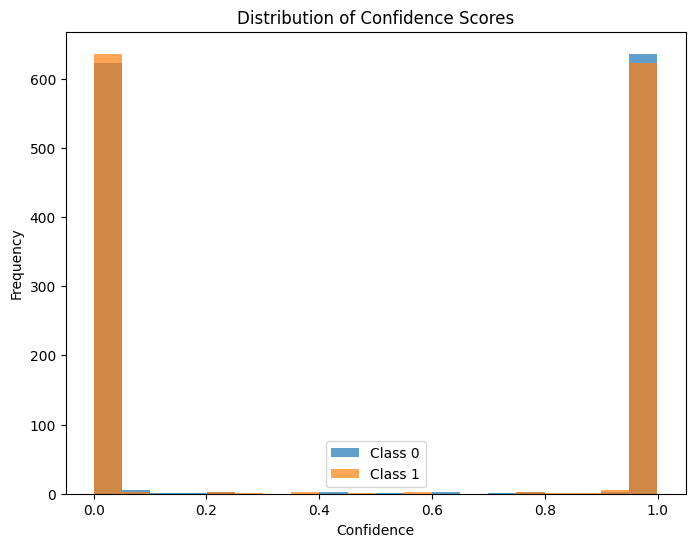

In [ ]:
import matplotlib.pyplot as plt
import torch

# Ensure `all_confidence_scores` is on the CPU and convert to NumPy
all_confidence_scores_np = all_confidence_scores.cpu().numpy()

# Extract confidences for each class
class_0_confidences = all_confidence_scores_np[:, 0]  # Confidence scores for Class 0
class_1_confidences = all_confidence_scores_np[:, 1]  # Confidence scores for Class 1

# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(class_0_confidences, bins=20, alpha=0.7, label="Class 0")  # Class 0 histogram
plt.hist(class_1_confidences, bins=20, alpha=0.7, label="Class 1")  # Class 1 histogram
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores")
plt.legend()
plt.show()


Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1 Score: 0.99


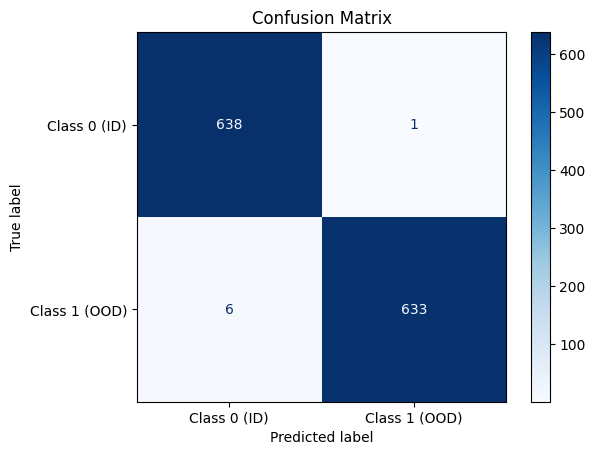

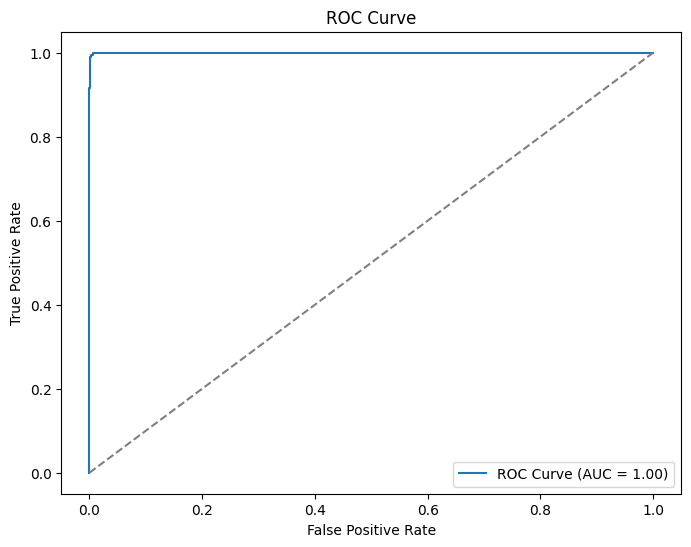

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import torch

# Assuming `all_confidence_scores` and `all_labels` are available
# Convert tensors to NumPy
all_confidence_scores_np = all_confidence_scores.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Extract confidence scores for Class 1 (positive class)
class_1_confidences = all_confidence_scores_np[:, 1]

# Threshold for classification (can be adjusted based on ROC analysis)
threshold = 0.5  # Example threshold
predicted_classes = (class_1_confidences >= threshold).astype(int)

# Metrics Calculation
accuracy = accuracy_score(all_labels_np, predicted_classes)
precision = precision_score(all_labels_np, predicted_classes)
recall = recall_score(all_labels_np, predicted_classes)
f1 = f1_score(all_labels_np, predicted_classes)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(all_labels_np, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0 (ID)", "Class 1 (OOD)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels_np, class_1_confidences)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Very High Accuracy and Recall, finetuning helped a lot.